### Boilerplate

In [ ]:
%run initialize.ipynb

In [ ]:
 ## custom rcParams settings for matplotlib
import sys
sys.path.append('../modeling-football-outcomes/config')
import mpl_style
colors = rcParams['axes.prop_cycle'].by_key()['color']

### Join/select to get needed data

In [3]:
key = 'game_id'
game = spark.table('game')\
                .select('game_id','season','week_id')\
                .cache()

game_outcome = spark.table('game_outcome')\
                .select('game_id','h_final','v_final')\
                .cache()

meta = spark.table('game_metadata')\
                .select('game_id','day_of_week')\
                .cache()

In [4]:
df = game.join(game_outcome, on=key).join(meta, on=key)
assert game.count() == df.count()
assert game_outcome.count() == df.count()
assert meta.count() == df.count()

In [5]:
df.limit(5).toPandas()

,game_id,season,week_id,h_final,v_final,day_of_week
0,201511150ram,2015,10,13,37,6
1,201511090sdg,2015,9,19,22,0
2,201510180det,2015,6,37,34,6
3,201512270tam,2015,16,21,26,6
4,201510110kan,2015,5,17,18,6


### Exploring League-wide Game Outcome Trends via Spark

#### Prep Data

In [6]:
df = df.withColumn(
            'winning_team', 
            F.when(col('h_final') > col('v_final'), 'H')
             .when(col('h_final') < col('v_final'), 'V')
             .otherwise('T')
        ).withColumn(
            'winning_score', 
            F.when(col('winning_team') == 'H', col('h_final'))
             .otherwise(col('v_final'))
        ).withColumn(
            'losing_score', 
            F.when(col('winning_team') == 'H', col('v_final'))
             .otherwise(col('h_final'))
        ).withColumn(
            'winning_margin', 
            F.abs(col('h_final') - col('v_final'))
        ).withColumn(
            'home_net', 
            col('h_final') - col('v_final')
        ).withColumn(
            'combined_points',
            col('h_final') + col('v_final')
        )

In [7]:
df.limit(5).toPandas()

,game_id,season,week_id,h_final,v_final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201511150ram,2015,10,13,37,6,V,37,13,24,-24,50
1,201511090sdg,2015,9,19,22,0,V,22,19,3,-3,41
2,201510180det,2015,6,37,34,6,H,37,34,3,3,71
3,201512270tam,2015,16,21,26,6,V,26,21,5,-5,47
4,201510110kan,2015,5,17,18,6,V,18,17,1,-1,35


#### 6 tie games from 2007-2017... this is correct per https://en.wikipedia.org/wiki/List_of_NFL_tied_games

In [8]:
df.filter(col('winning_team') == 'T').toPandas()

,game_id,season,week_id,h_final,v_final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201610230crd,2016,7,6,6,6,T,6,6,0,0,12
1,201211110sfo,2012,10,24,24,6,T,24,24,0,0,48
2,201311240gnb,2013,12,26,26,6,T,26,26,0,0,52
3,201410120cin,2014,6,37,37,6,T,37,37,0,0,74
4,200811160cin,2008,11,13,13,6,T,13,13,0,0,26
5,201610300cin,2016,8,27,27,6,T,27,27,0,0,54


#### Has the Home-Field Advantage Effect Changed over Time?

In [9]:
winners = df.groupby('winning_team')\
            .count()\
            .toPandas()\
            .set_index('winning_team')
print 'home team wins {:.1f}% of the time'.format(
    winners.loc['H','count'].astype(float) / winners['count'].sum()*100
)
winners

home team wins 57.0% of the time


,count
winning_team,
T,6
V,1257
H,1674


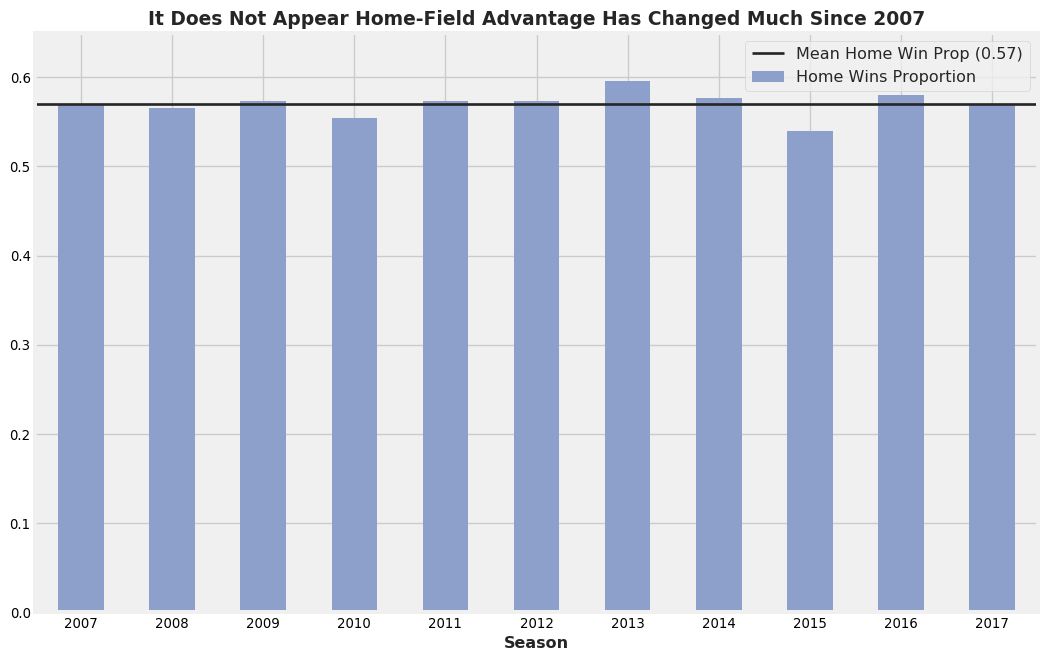

In [10]:
_ = df.groupby('season')\
    .pivot('winning_team')\
    .count()\
    .withColumnRenamed('season', 'Season')\
    .withColumn(
        'Home Wins Proportion',
        col('H') / ( col('H') + F.coalesce('T', F.lit(0)) + col('V') )
    ).toPandas()\
    .set_index('Season')\
    .sort_index()\
    .loc[:, 'Home Wins Proportion']\
    .plot(
        kind='bar', color=colors[2], rot=0,
        title='It Does Not Appear Home-Field Advantage Has Changed Much Since 2007'
    )
_ = plt.axhline(y=0.57, label='Mean Home Win Prop (0.57)', linewidth=2)
_ = plt.ylim([0, 0.65])
_ = plt.legend()

#### How Have Scores and Margins of Victory Changed Over Time?

In [11]:
def agg_scores(df, ngames, scores):
    scores = df.withColumn('prop', F.lit(1) / ngames)\
                       .groupby(scores)\
                       .agg(F.sum('prop').alias('prop'))\
                       .toPandas()\
                       .set_index(scores)\
                       .sort_index()

    assert np.abs(scores['prop'].sum() - 1) < 1e-10

    new_index = np.arange(
        scores.index.min(),
        scores.index.max()+1,
    )

    return scores.reindex(new_index).fillna(0)

ngames = F.lit(float(df.count()))
winning_scores = agg_scores(df, ngames, 'winning_score')
losing_scores = agg_scores(df, ngames, 'losing_score')
margin = agg_scores(df, ngames, 'winning_margin')
home_net = agg_scores(df, ngames, 'home_net')
combined = agg_scores(df, ngames, 'combined_points')

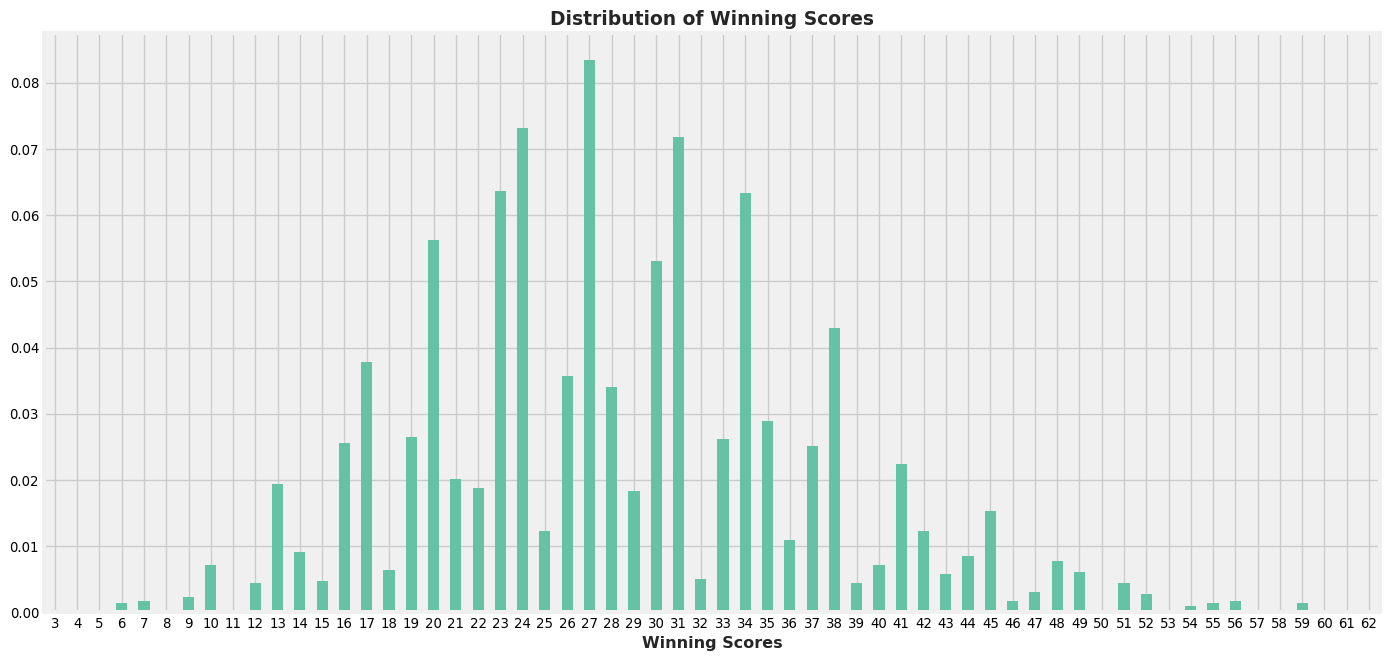

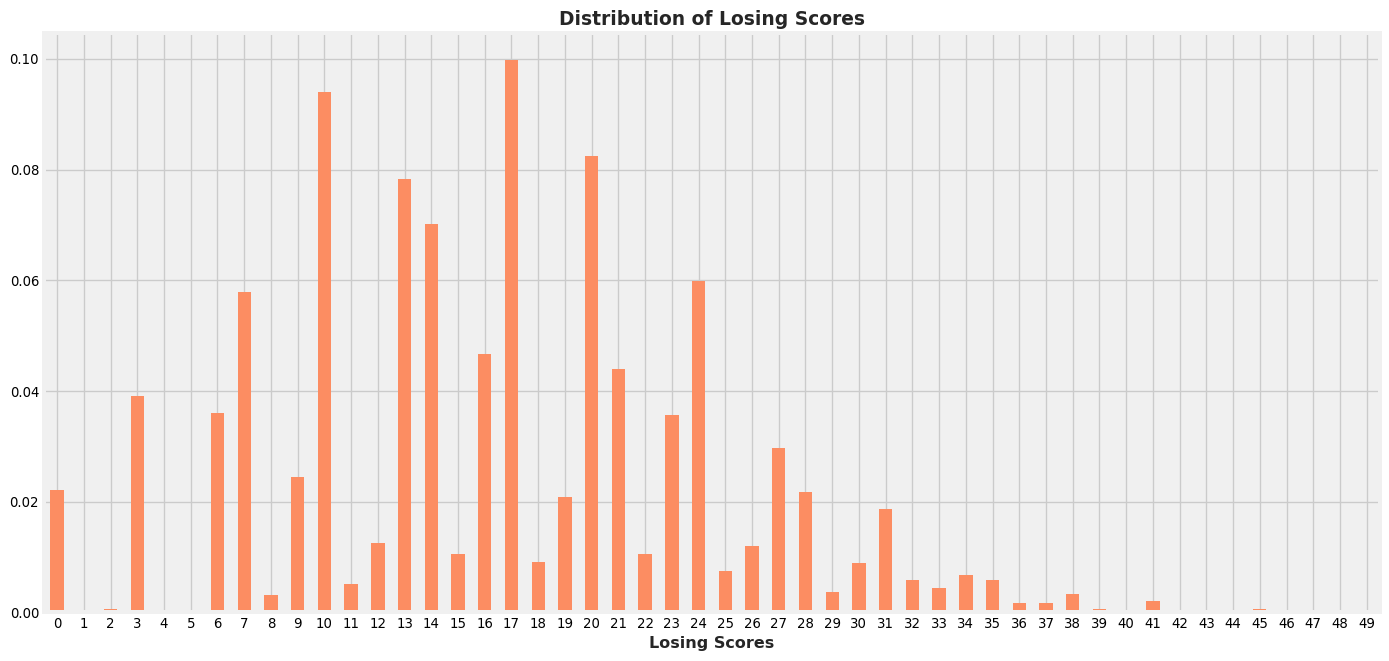

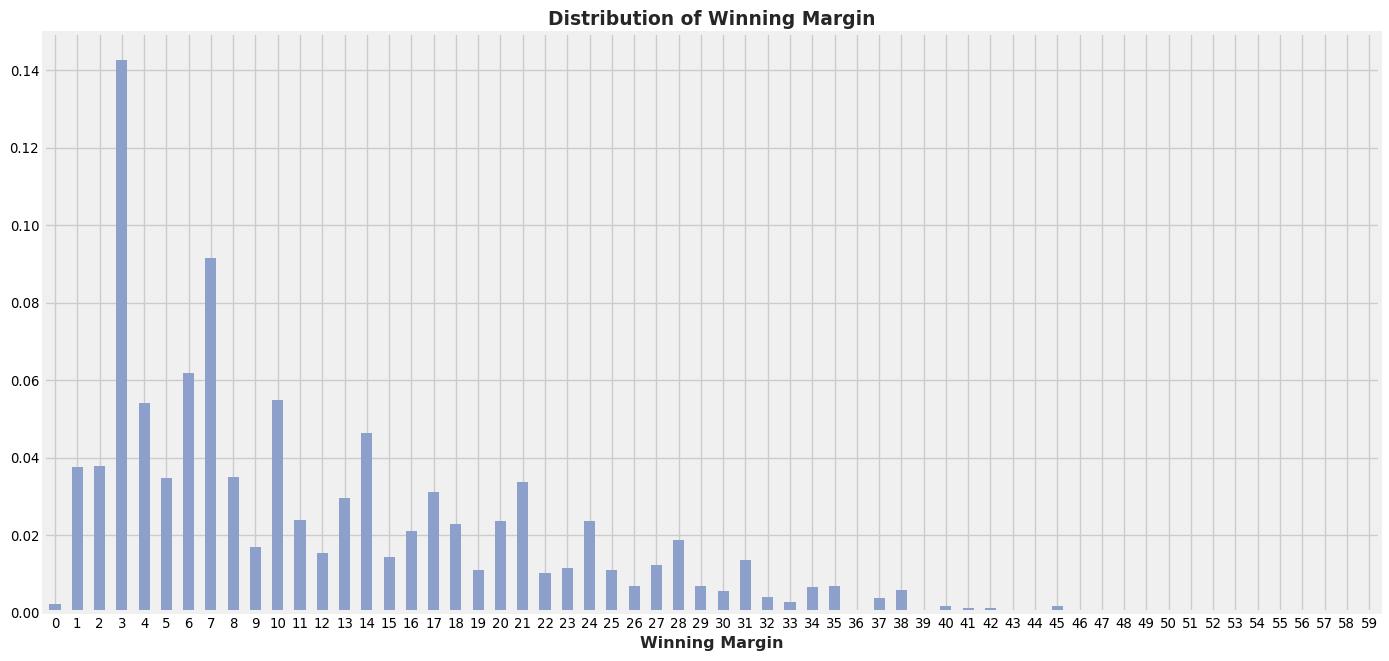

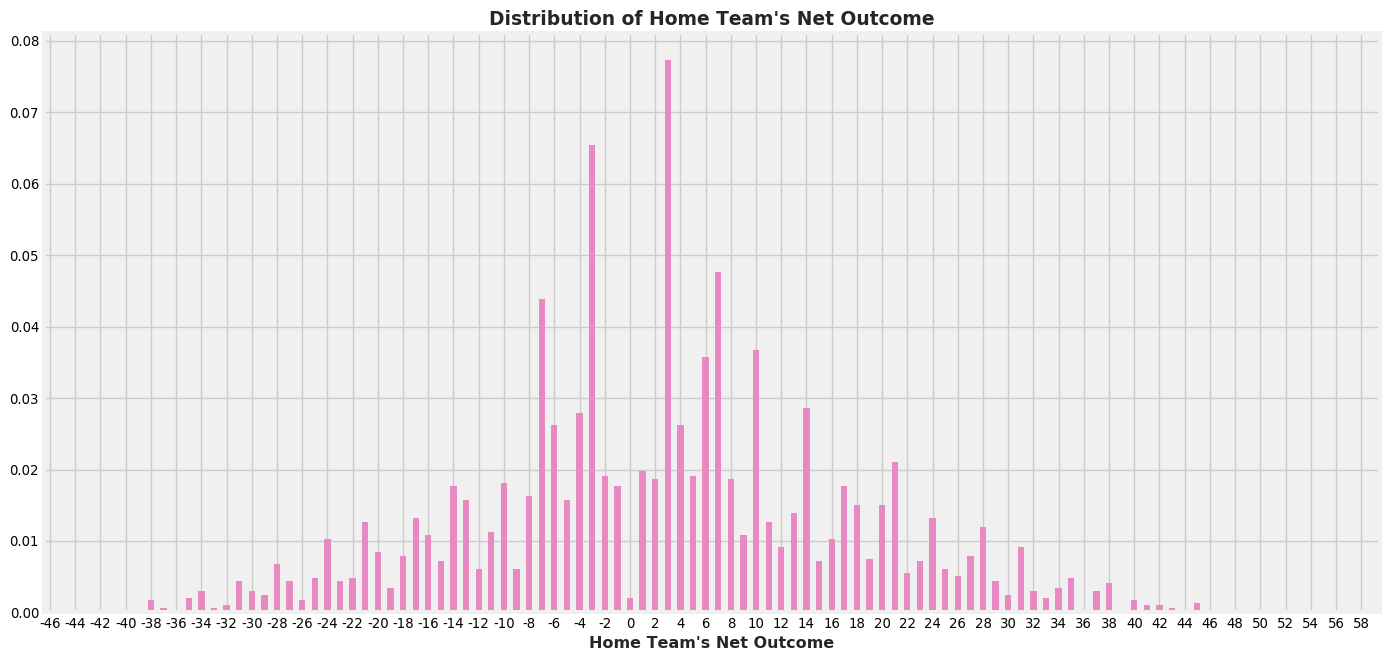

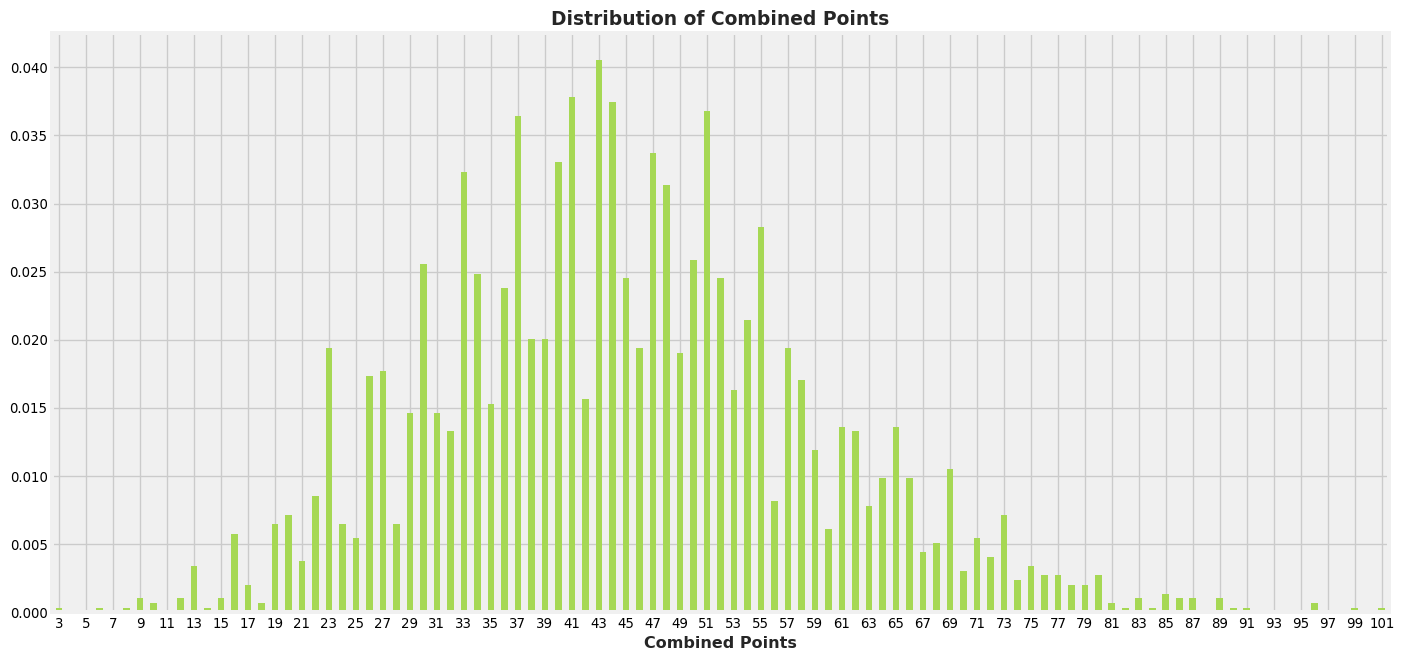

In [12]:
def plot_dist(df, title_prefix, base_title, skiptick, i, plot_type):
    title = 'Distribution of {}'.format(base_title)
    if title_prefix:
        title = '{} {}'.format(title_prefix, title)
    
    df.plot(
        kind=plot_type, figsize=(16,8), rot=0, color=colors[i], 
        legend=None, title=title
    )
    if title_prefix == 'Rolling':
        plt.axhline(y=0.5, color=colors[-1], alpha=0.5, linewidth=2)
    
    plt.xlabel(base_title)
    
    ## skip some tick labels if they're too crowded
    if skiptick > 1:
        a, b = plt.xticks()
        plt.xticks(a[::skiptick], b[::skiptick])
        
        

plot_data = [
    (winning_scores, '', 'Winning Scores', 1),
    (losing_scores, '', 'Losing Scores', 1),
    (margin, '', 'Winning Margin', 1),
    (home_net, '', 'Home Team\'s Net Outcome', 2),
    (combined, '', 'Combined Points', 2),
]

for i, (data, title_prefix, title, skiptick) in enumerate(plot_data):
    plot_dist(data, title_prefix, title, skiptick, i, 'bar')

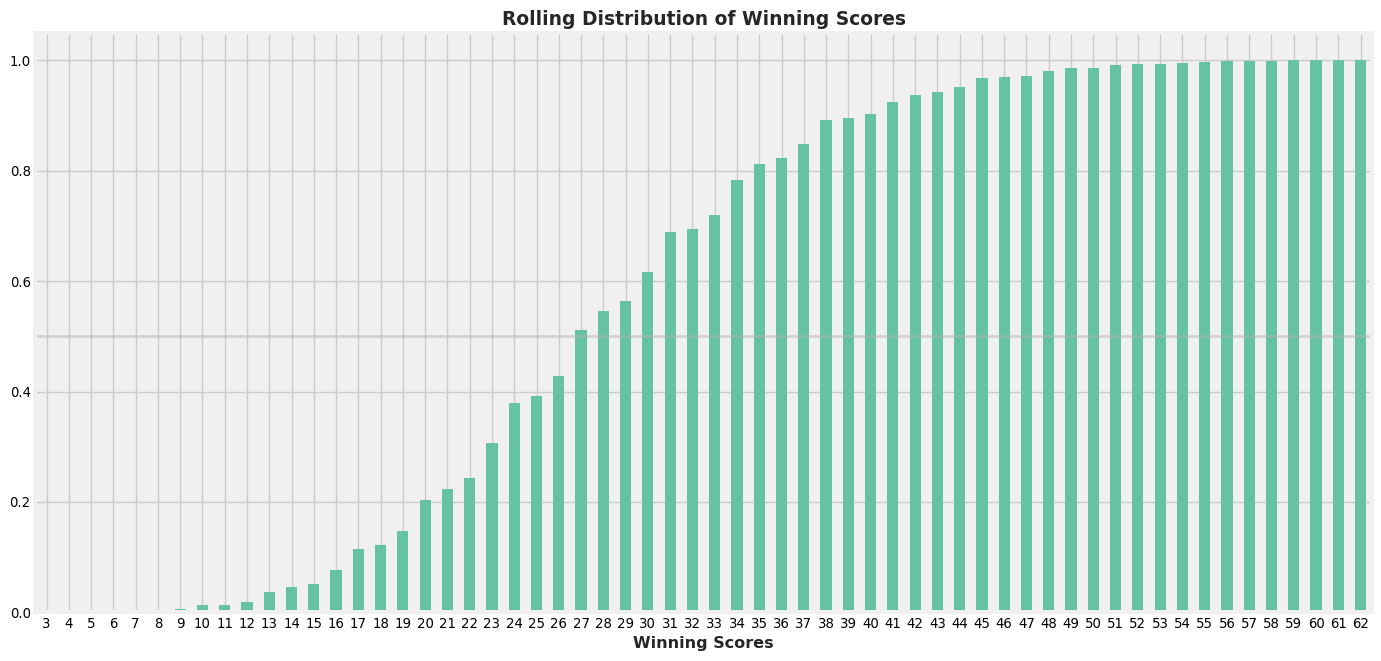

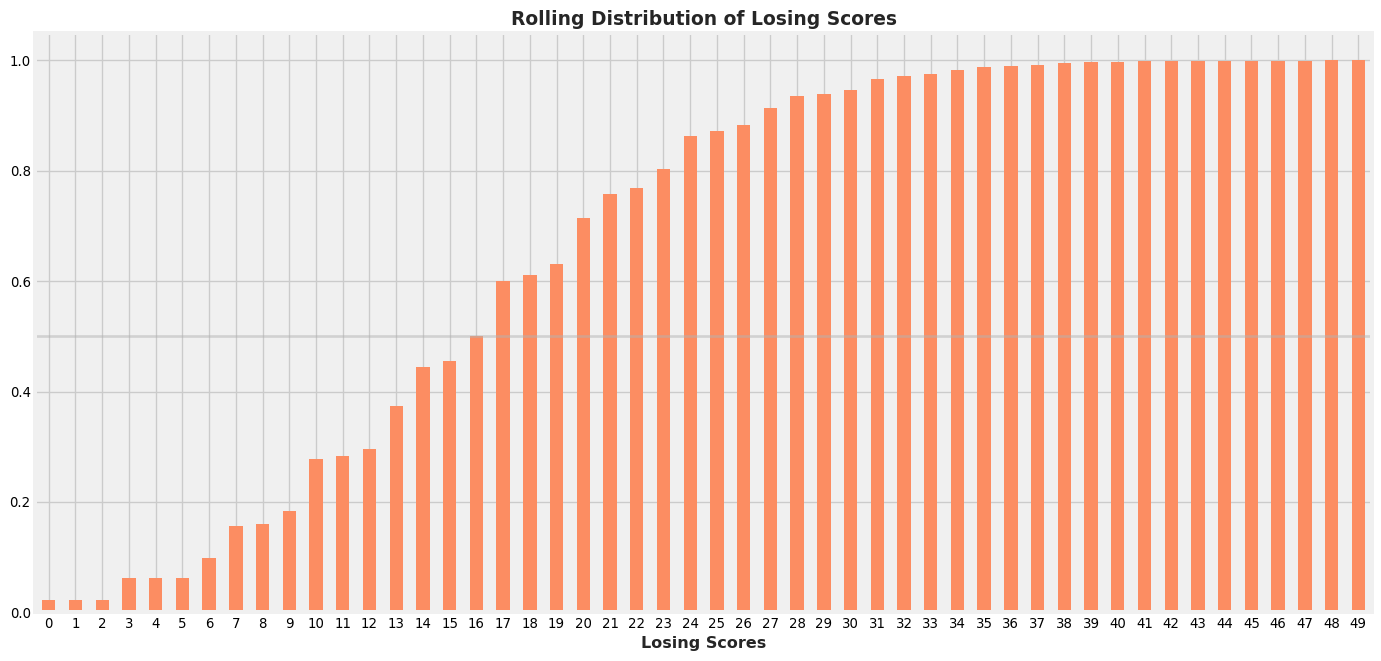

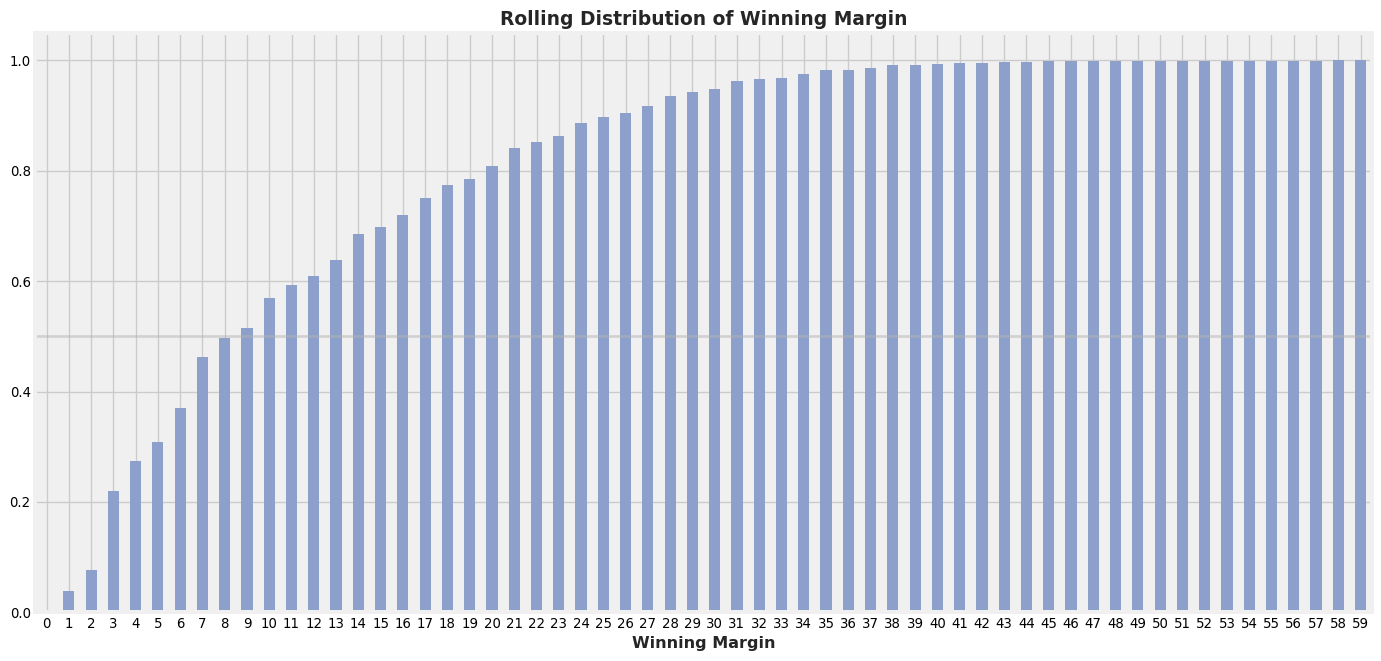

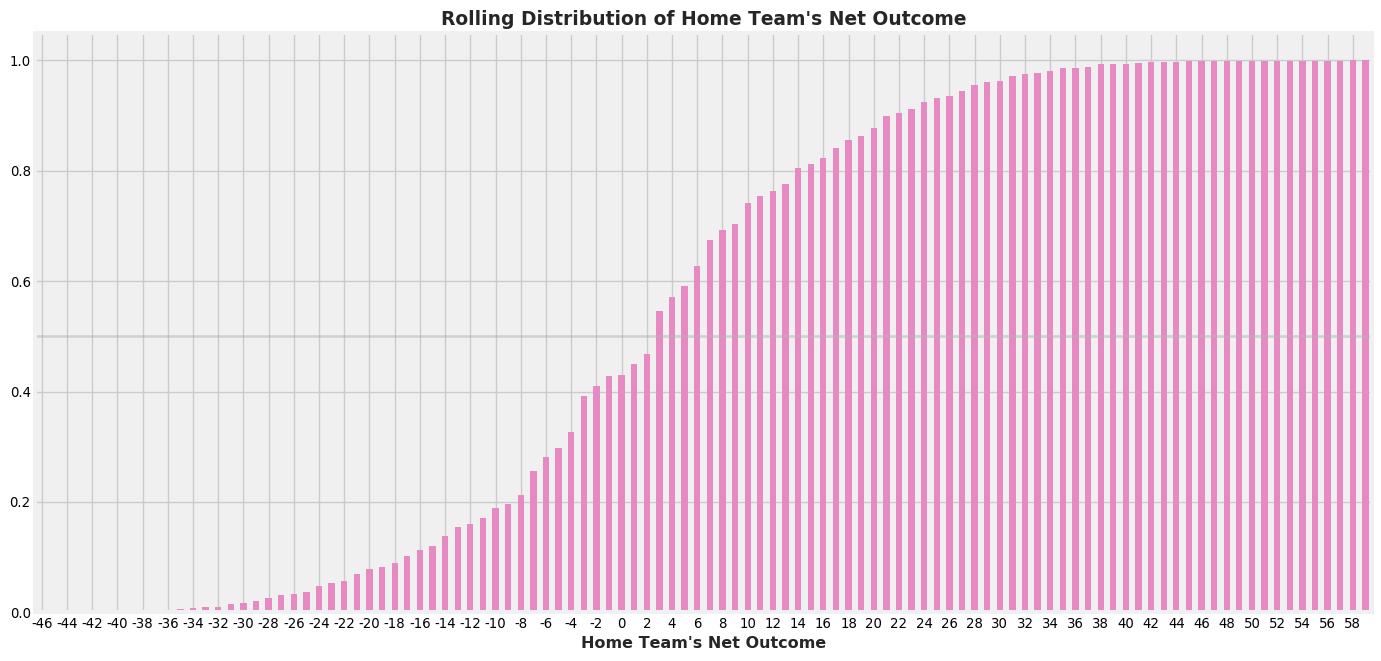

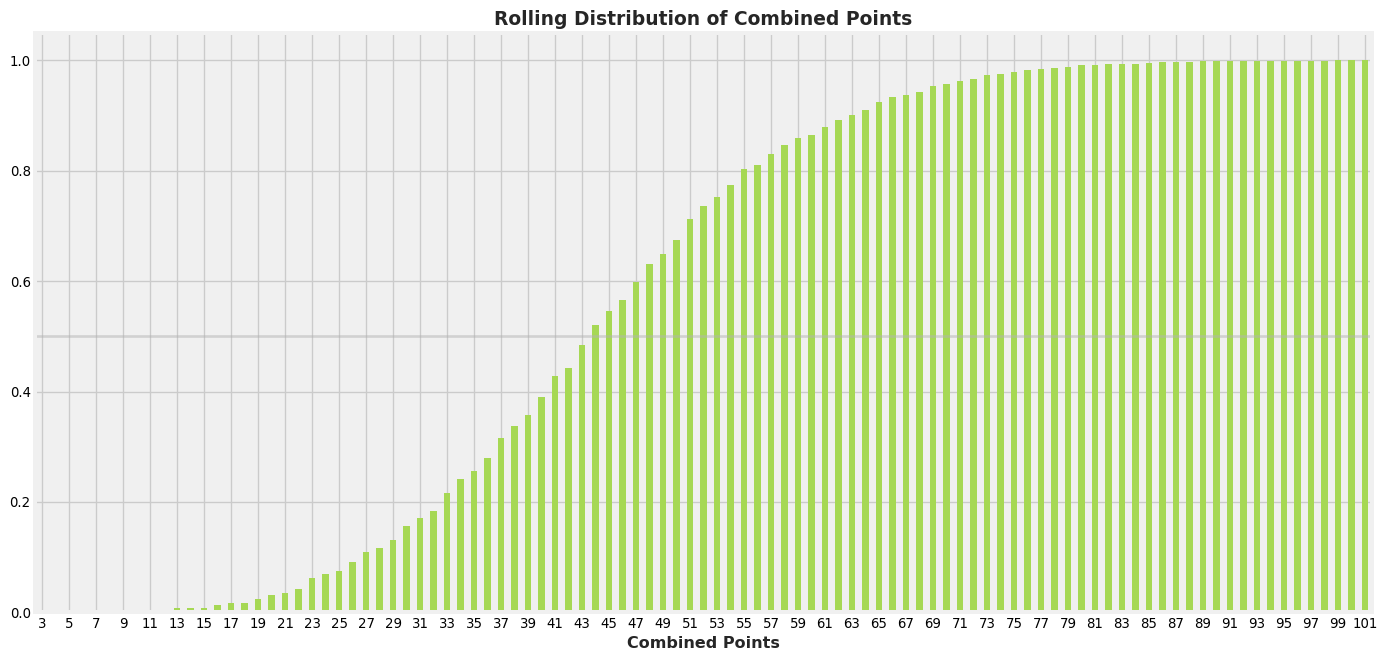

In [13]:
plot_data = [
    (winning_scores.cumsum(), 'Rolling', 'Winning Scores', 1),
    (losing_scores.cumsum(), 'Rolling', 'Losing Scores', 1),
    (margin.cumsum(), 'Rolling', 'Winning Margin', 1),
    (home_net.cumsum(), 'Rolling', 
     'Home Team\'s Net Outcome', 2),
    (combined.cumsum(), 'Rolling', 'Combined Points', 2),
]

for i, (data, title_prefix, title, skiptick) in enumerate(plot_data):
    plot_dist(data, title_prefix, title, skiptick, i, 'bar')

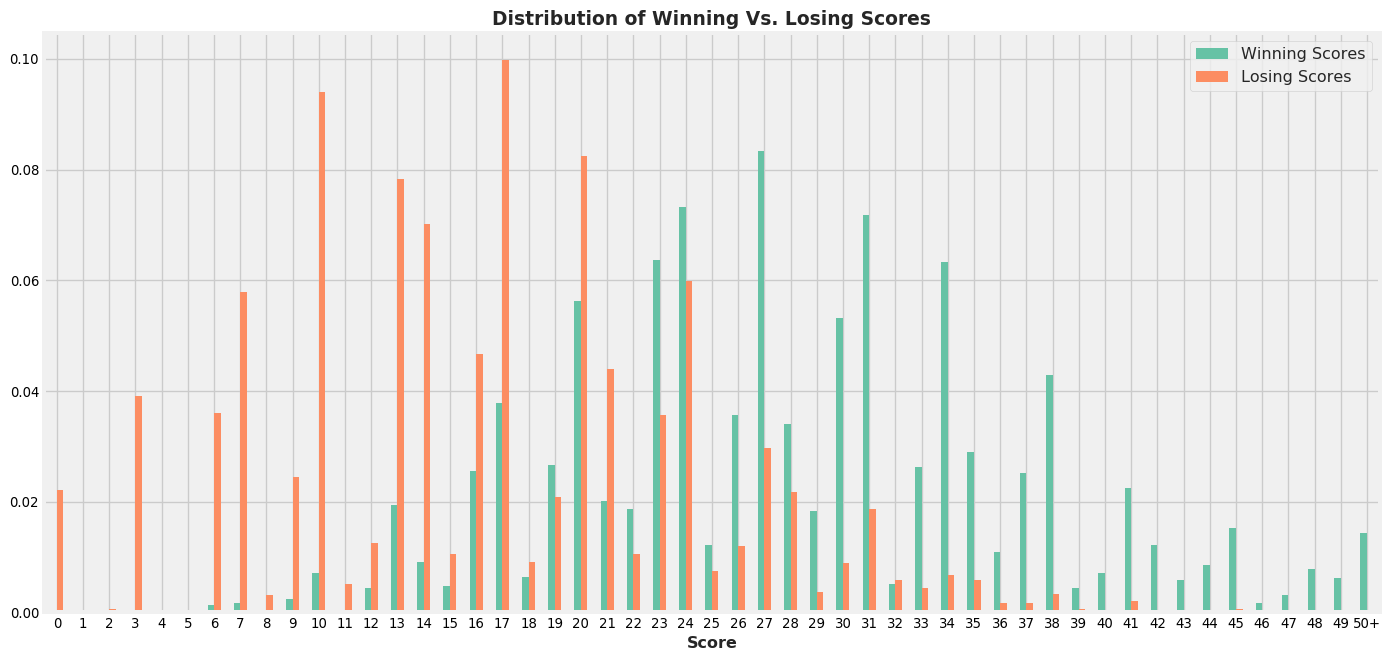

In [14]:
combined_scores = winning_scores.rename(
        columns={'prop':'Winning Scores'}
    ).merge(
        losing_scores.rename(columns={'prop':'Losing Scores'}), 
        left_index=True, right_index=True, how='outer'
    ).fillna(0)

max_losing = combined_scores[combined_scores['Losing Scores'] > 0].index.max()

combined_scores.index.name = 'Score'
combined_scores = combined_scores.reset_index(drop=False)
winning_top_bin = combined_scores[combined_scores['Score'] > max_losing]\
                        ['Winning Scores'].sum()

combined_scores = combined_scores[combined_scores['Score'] <= max_losing]
idx = combined_scores.index.max()+1
combined_scores.loc[idx, :] = ['{}+'.format(max_losing+1), winning_top_bin, 0]
combined_scores['Score'] = combined_scores['Score'].apply(
    lambda x: str(x).split('.')[0]
)
combined_scores.set_index('Score', inplace=True)

_ = combined_scores.plot(
    kind='bar', figsize=(16,8), rot=0
)
_ = plt.title(
    'Distribution of Winning Vs. Losing Scores', 
    color='#262626', fontsize=14, fontweight='bold'
 )

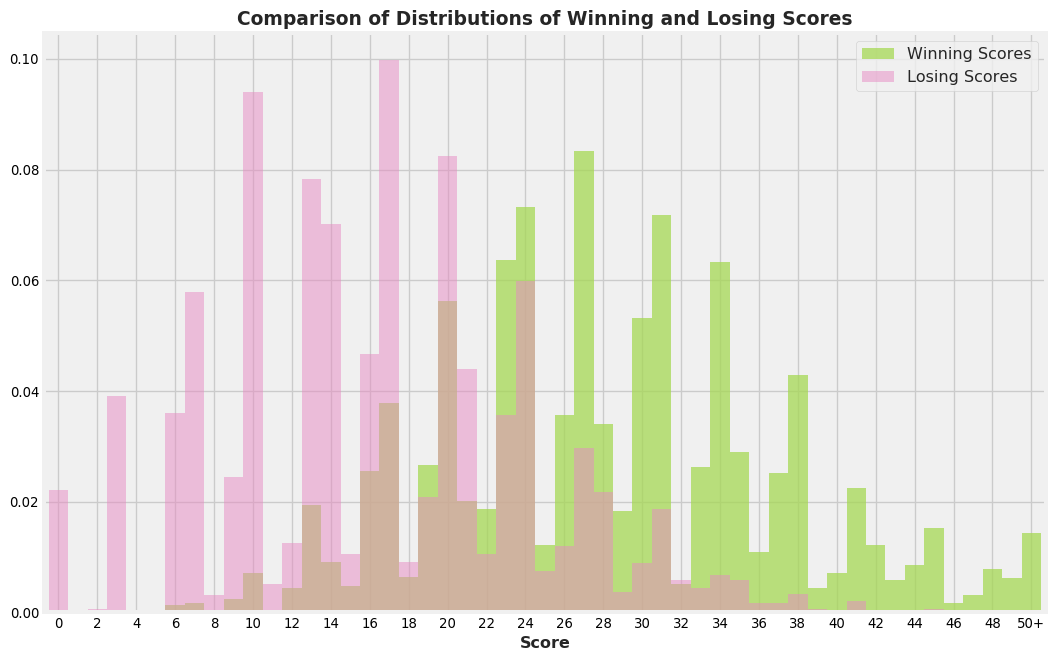

In [15]:
ax = plt.figure().add_subplot(111)

_ = combined_scores['Winning Scores'].plot(
        kind='bar', rot=0, width=1, ax=ax, color=colors[4], alpha=0.75,
        title='Comparison of Distributions of Winning and Losing Scores'
    )
_ = combined_scores['Losing Scores'].plot(
        kind='bar', rot=0, width=1, color=colors[3], ax=ax, alpha=0.5
    )

a, b = plt.xticks()
_ = plt.xticks(a[::2], b[::2])
_ = plt.legend()

#### What are the most common scores and winning margins

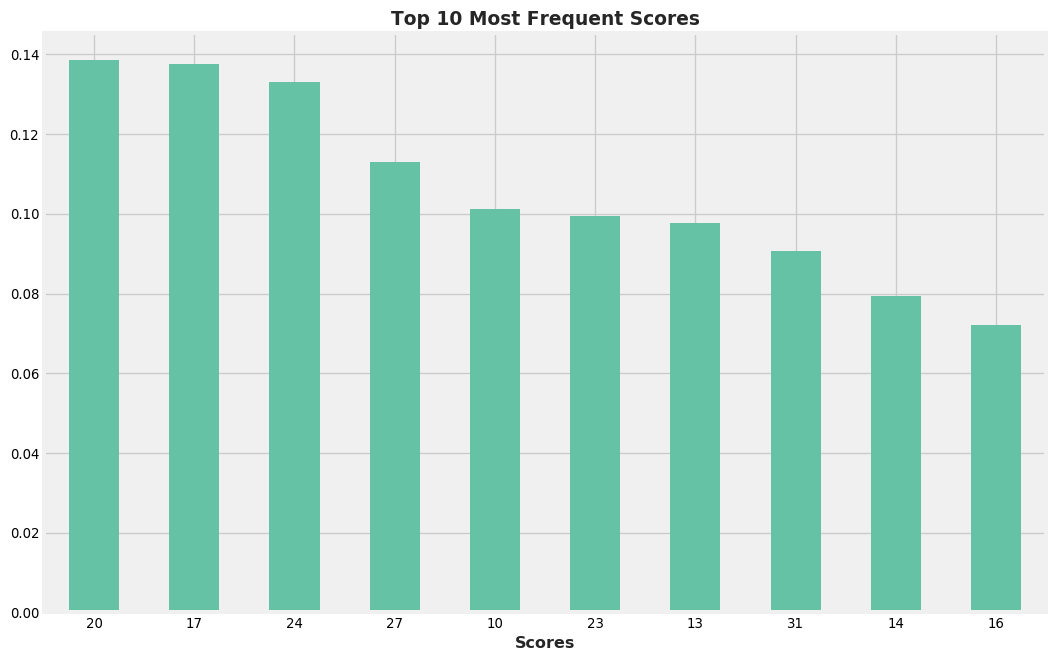

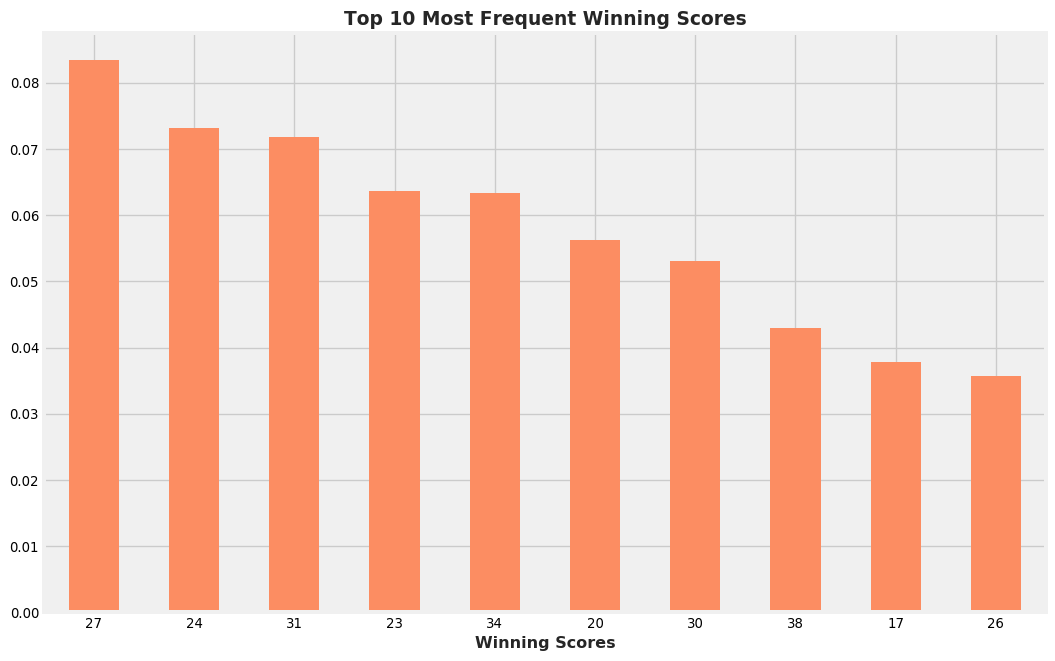

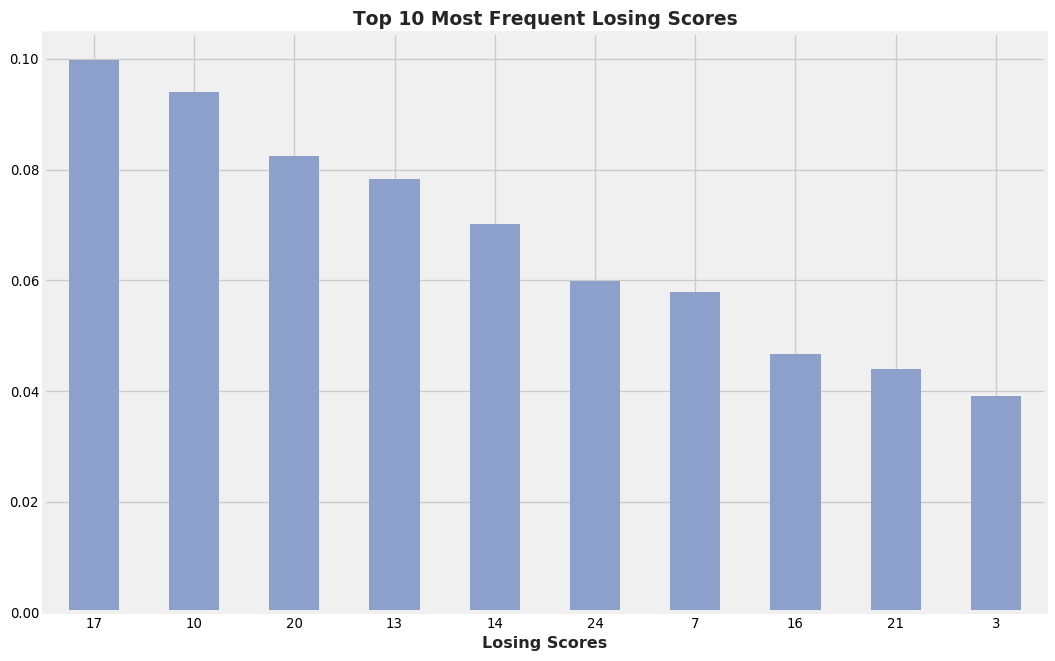

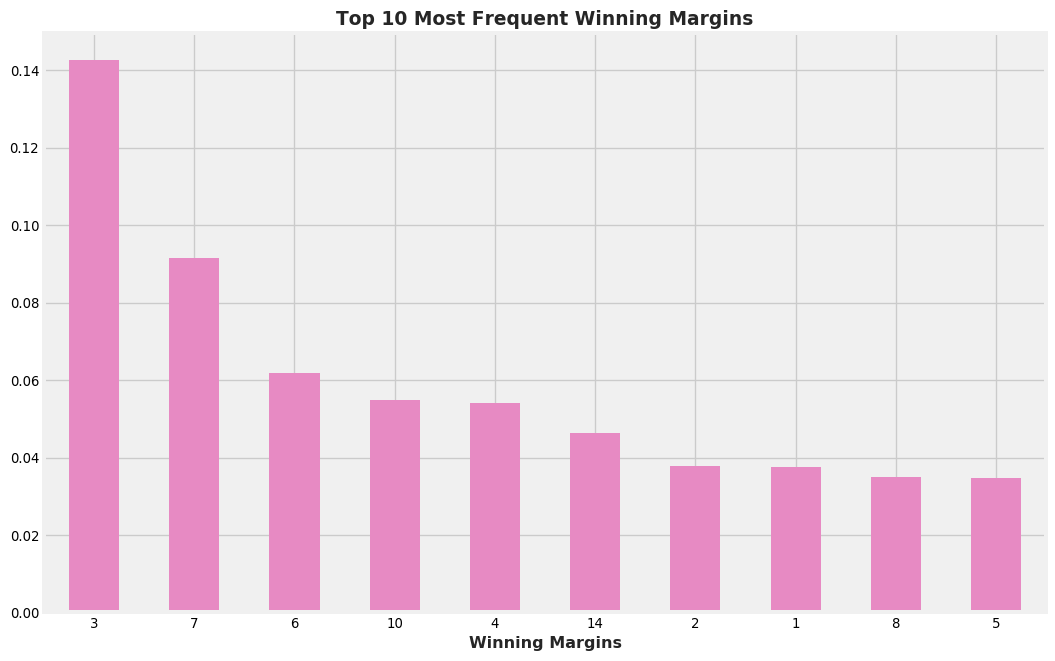

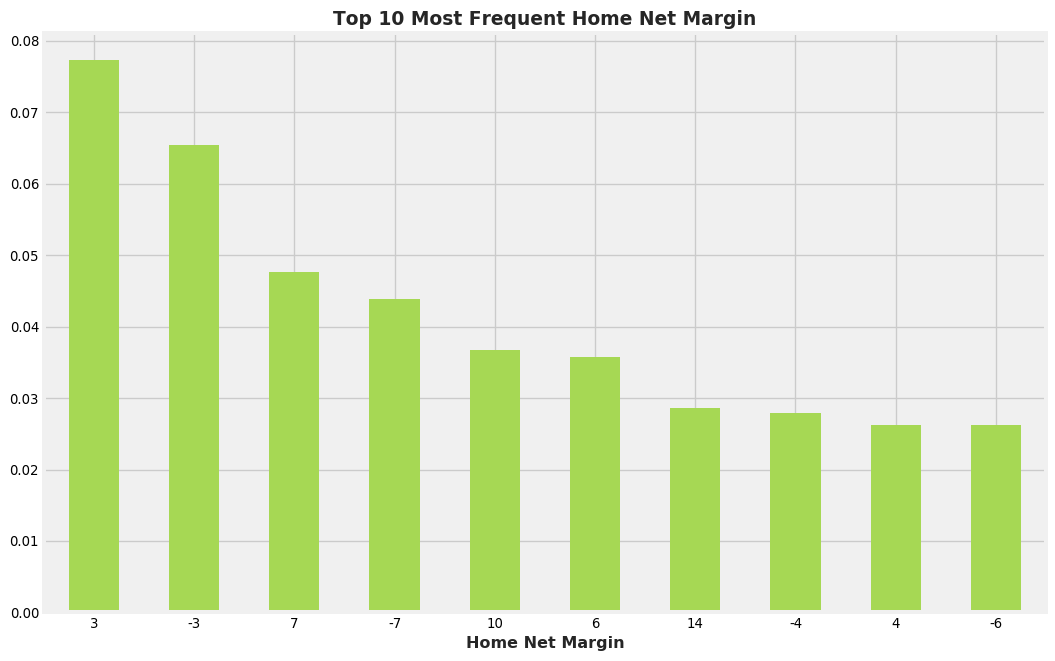

In [16]:
def plot_top_10s(df, title, i):
    '''plot a bar chart with the greatest 10 values'''
    _ = df.sort_values(by='prop', ascending=False).head(10).plot(
            kind='bar', rot=0, legend=None, color=colors[i]
            )
    _ = plt.title('Top 10 Most Frequent {}'.format(title))
    _ = plt.xlabel(title)
    
all_scores = pd.DataFrame(
    winning_scores.merge(
        losing_scores, left_index=True, right_index=True, how='outer'
    ).fillna(0).sum(axis=1)
).rename(columns={0:'prop'})

top_10s = [
    (all_scores, 'Scores'),
    (winning_scores, 'Winning Scores'),
    (losing_scores, 'Losing Scores'),
    (margin, 'Winning Margins'),
    (home_net, 'Home Net Margin')
]

for i, (data, title) in enumerate(top_10s):
    plot_top_10s(data, title, i)

#### How does the margin of error and/or winning score change over (1) time, (2) week, (3) day of week?

In [17]:
df.limit(5).toPandas()

,game_id,season,week_id,h_final,v_final,day_of_week,winning_team,winning_score,losing_score,winning_margin,home_net,combined_points
0,201511150ram,2015,10,13,37,6,V,37,13,24,-24,50
1,201511090sdg,2015,9,19,22,0,V,22,19,3,-3,41
2,201510180det,2015,6,37,34,6,H,37,34,3,3,71
3,201512270tam,2015,16,21,26,6,V,26,21,5,-5,47
4,201510110kan,2015,5,17,18,6,V,18,17,1,-1,35


In [18]:
field = 'winning_score'
pivot_col = 'season'

time_trend = df.groupby(field)\
                .pivot(pivot_col)\
                .count()\
                .toPandas()\
                .fillna(0)\
                .set_index(field)

new_index = np.arange(
    time_trend.index.min(),
    time_trend.index.max()+1,
)

time_trend = time_trend.reindex(new_index).fillna(0)

for c in time_trend.columns:
    tot = float(time_trend[c].sum())
    time_trend[c] /= tot

time_trend.head()

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
winning_score,,,,,,,,,,,
3,0.003745,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,0.000000,0.0,0.003745,0.000000,0.003745,0.000000,0.0,0.0,0.0,0.003745,0.003745
7,0.000000,0.0,0.003745,0.003745,0.003745,0.007491,0.0,0.0,0.0,0.000000,0.000000


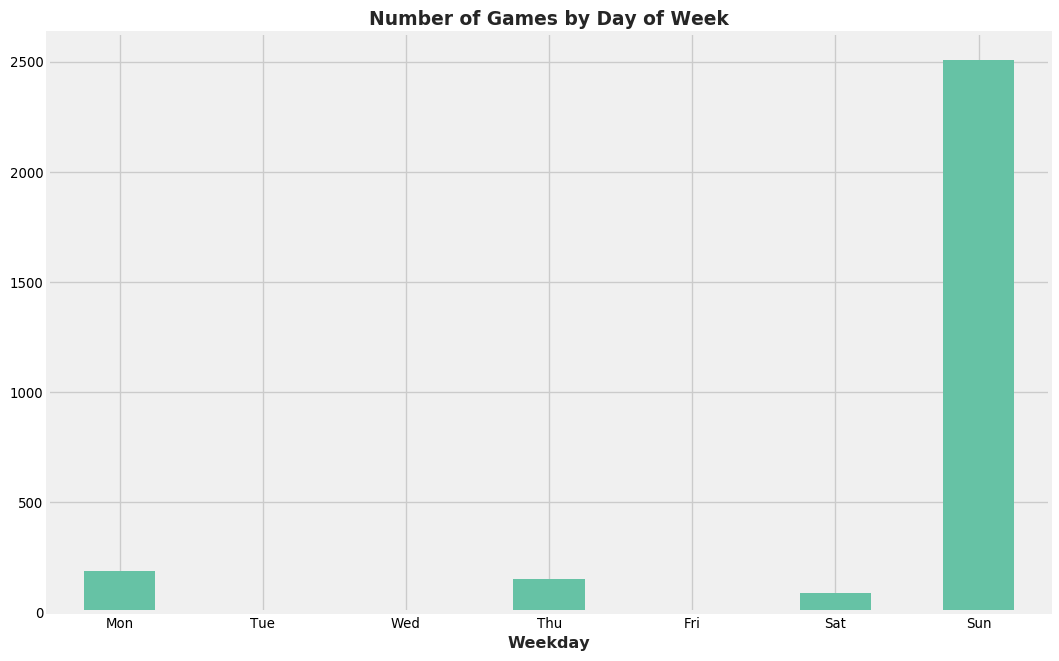

In [19]:
dow_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}
dow_map_udf = udf(lambda x: dow_map[x], StringType())

df = df.withColumn('Weekday', dow_map_udf('day_of_week'))
df.groupby('Weekday','day_of_week')\
    .count()\
    .orderBy('day_of_week')\
    .drop('day_of_week')\
    .toPandas()\
    .set_index('Weekday')\
    .plot(
        kind='bar', title='Number of Games by Day of Week', 
        legend=None, rot=0
        )

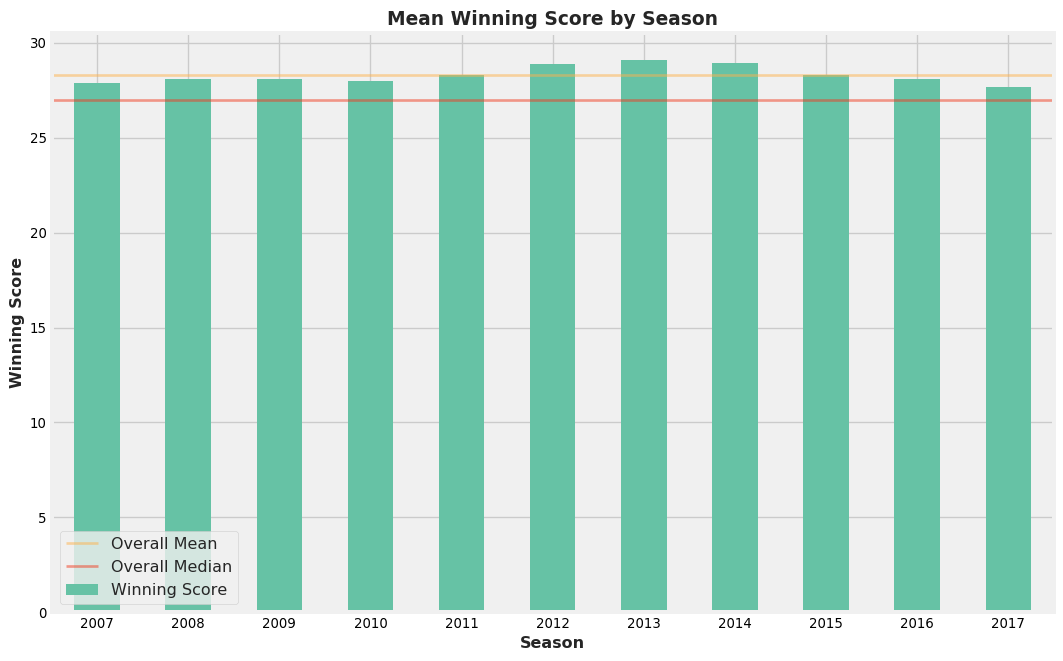

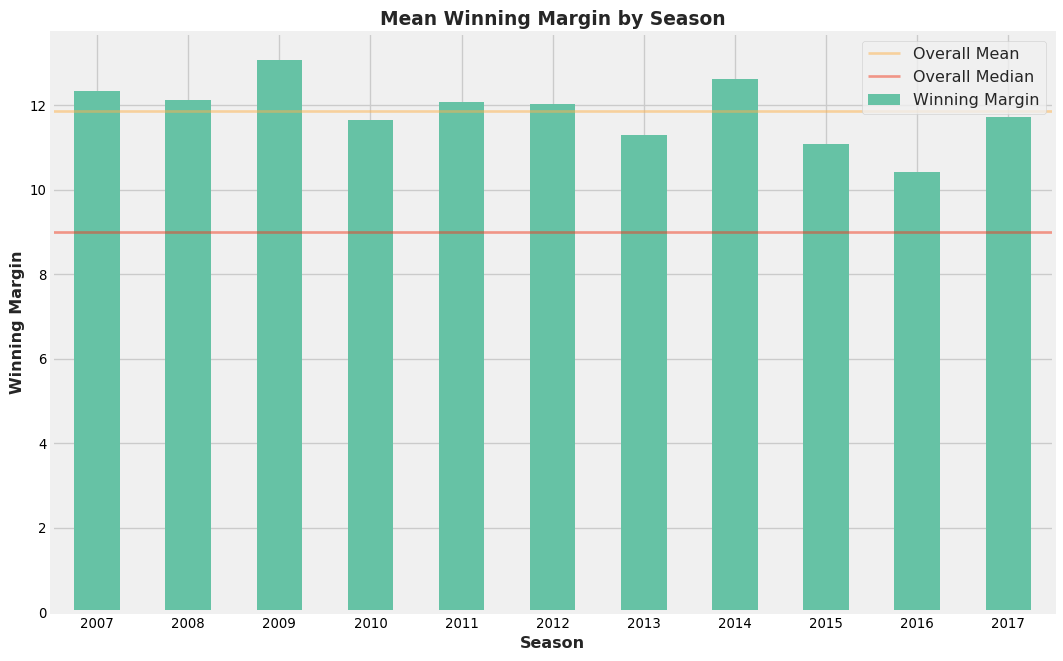

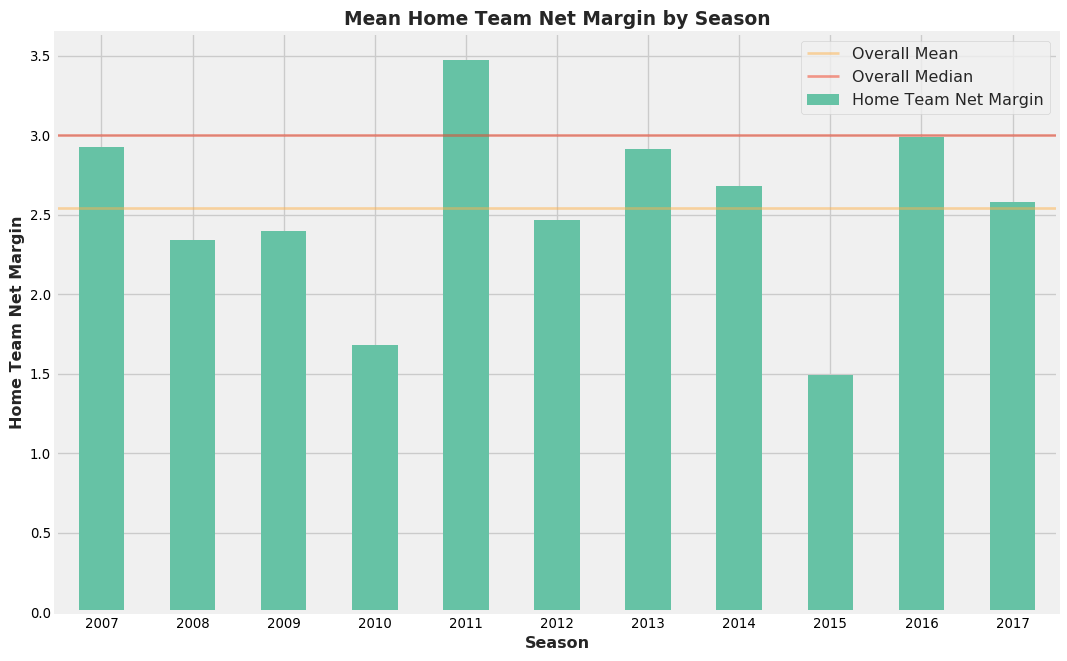

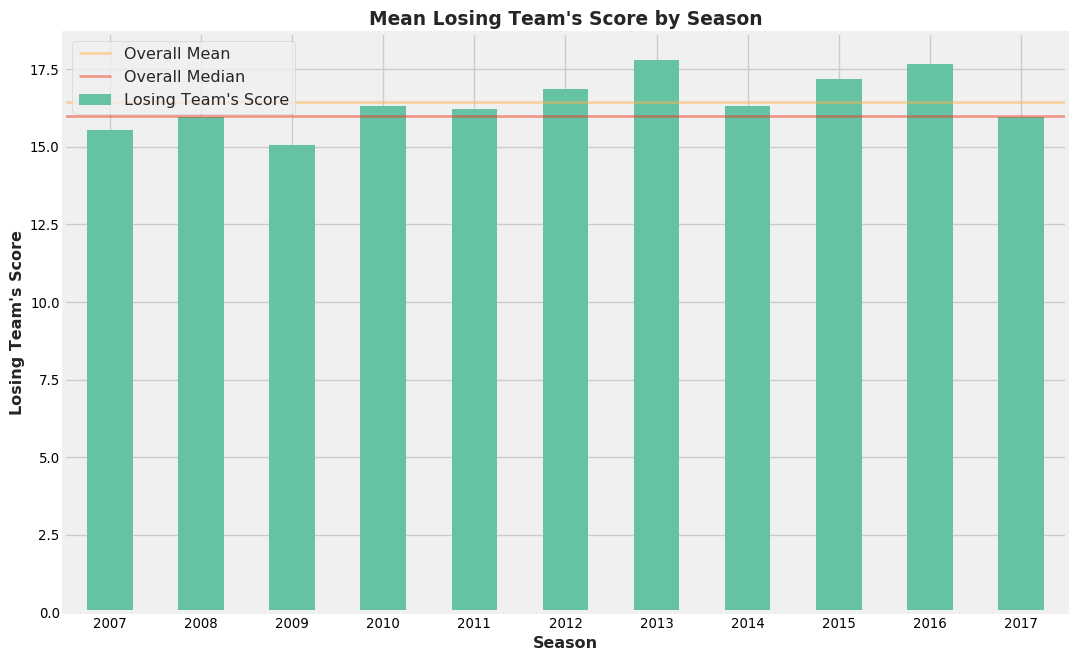

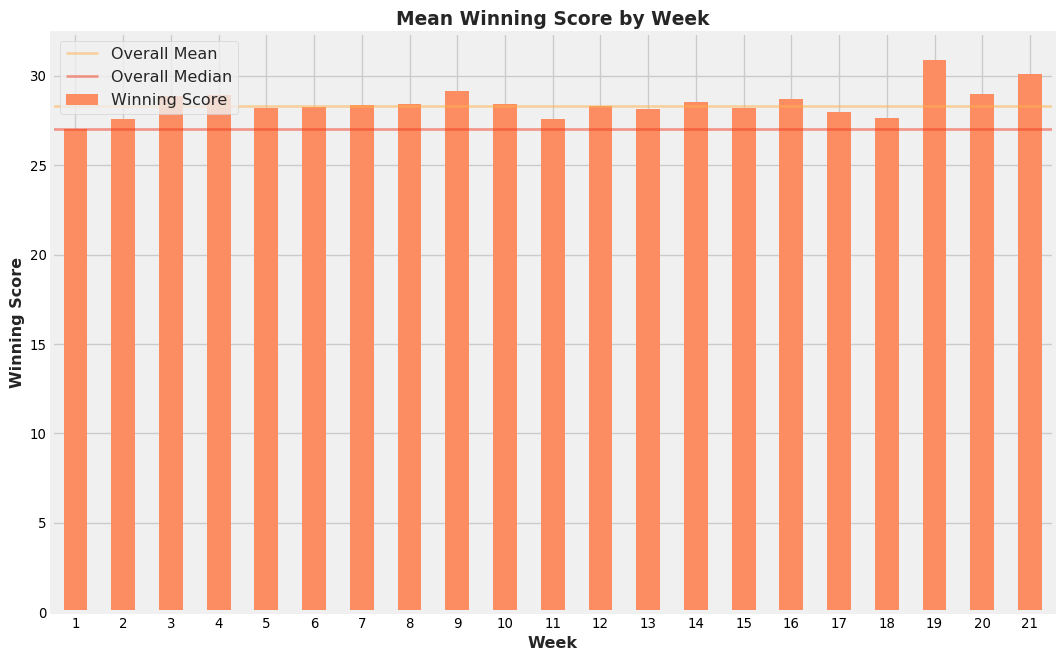

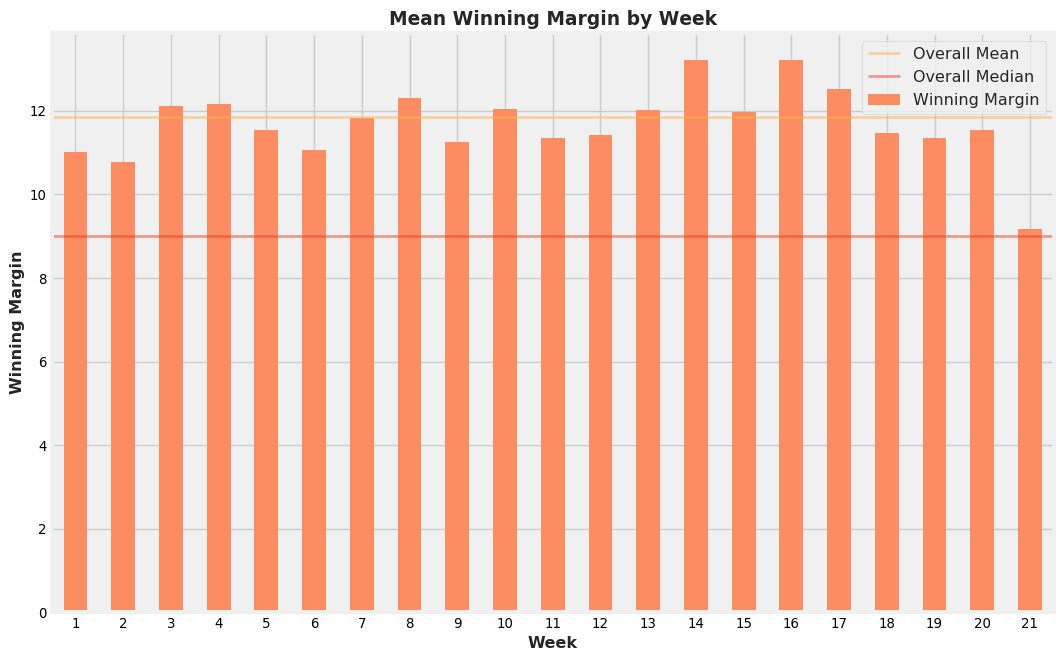

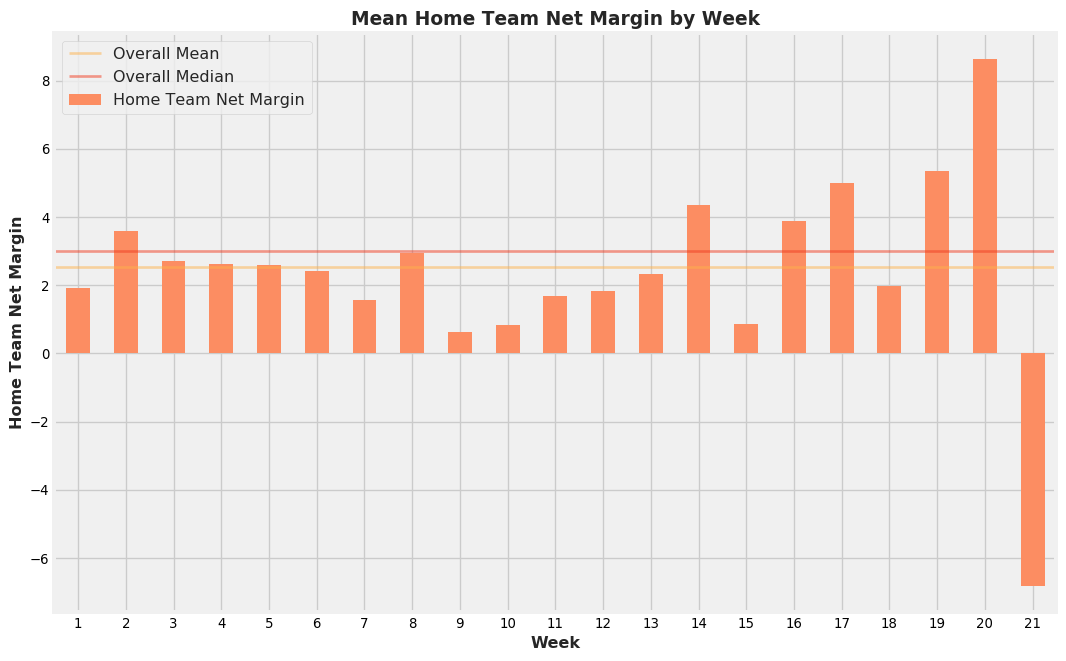

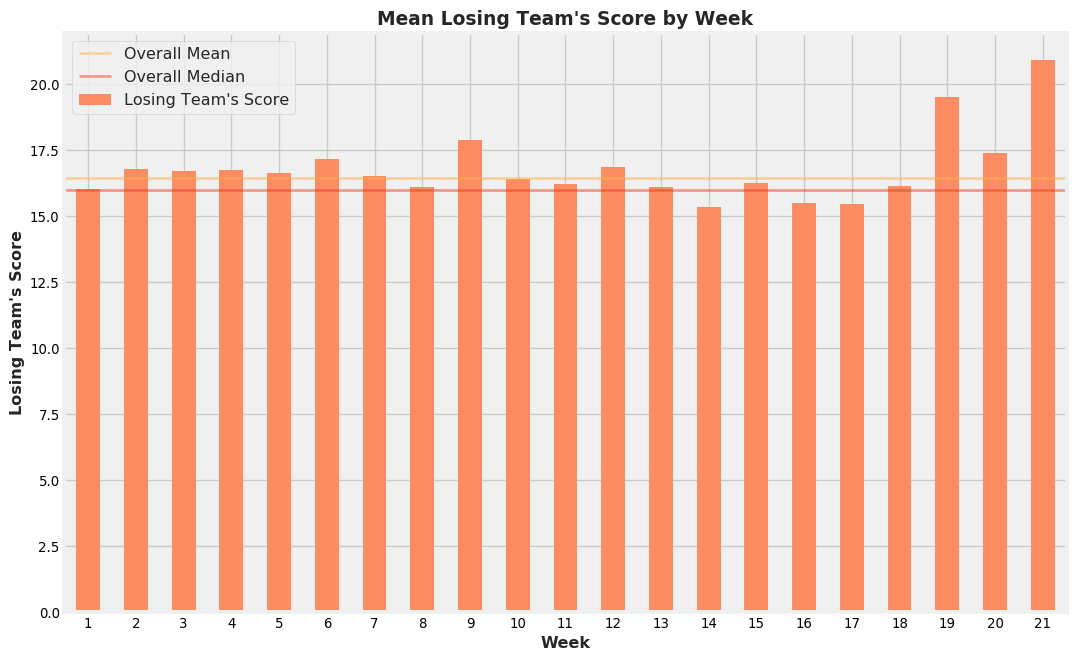

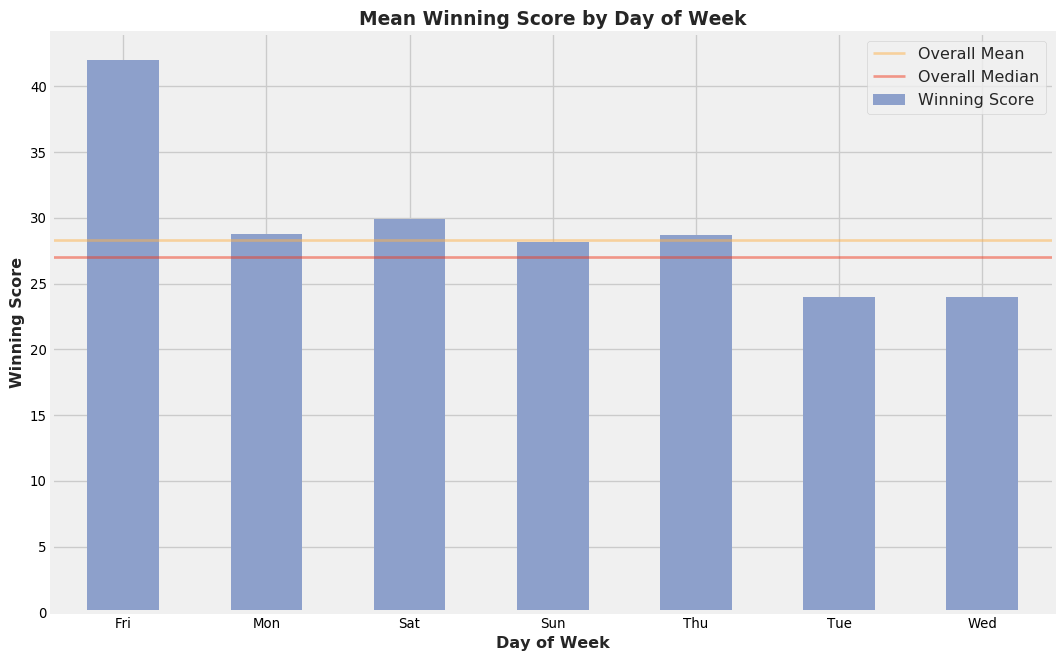

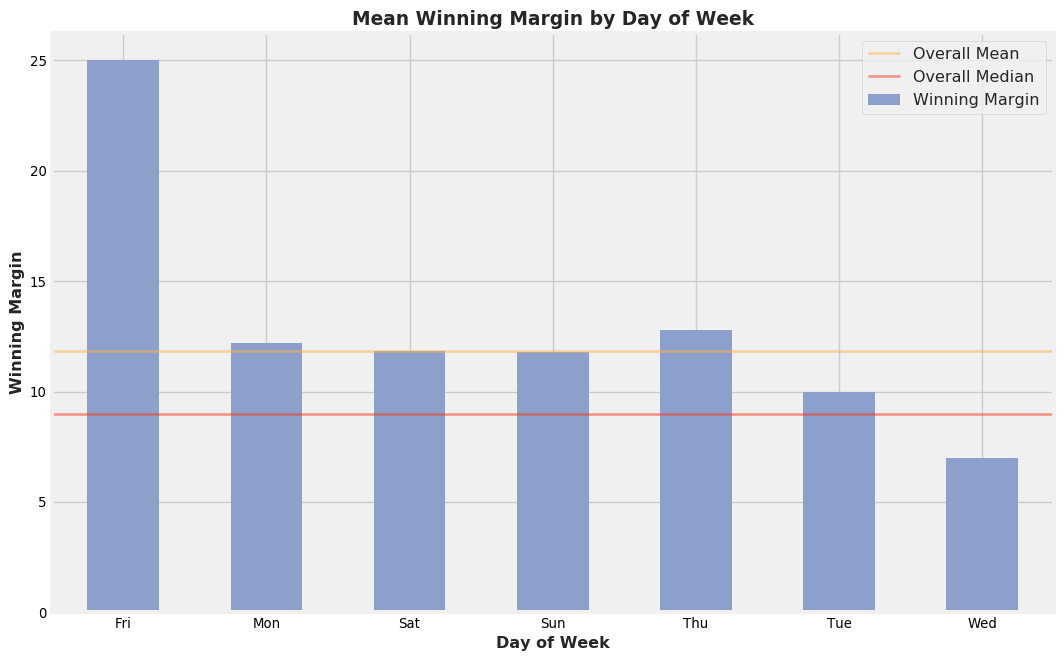

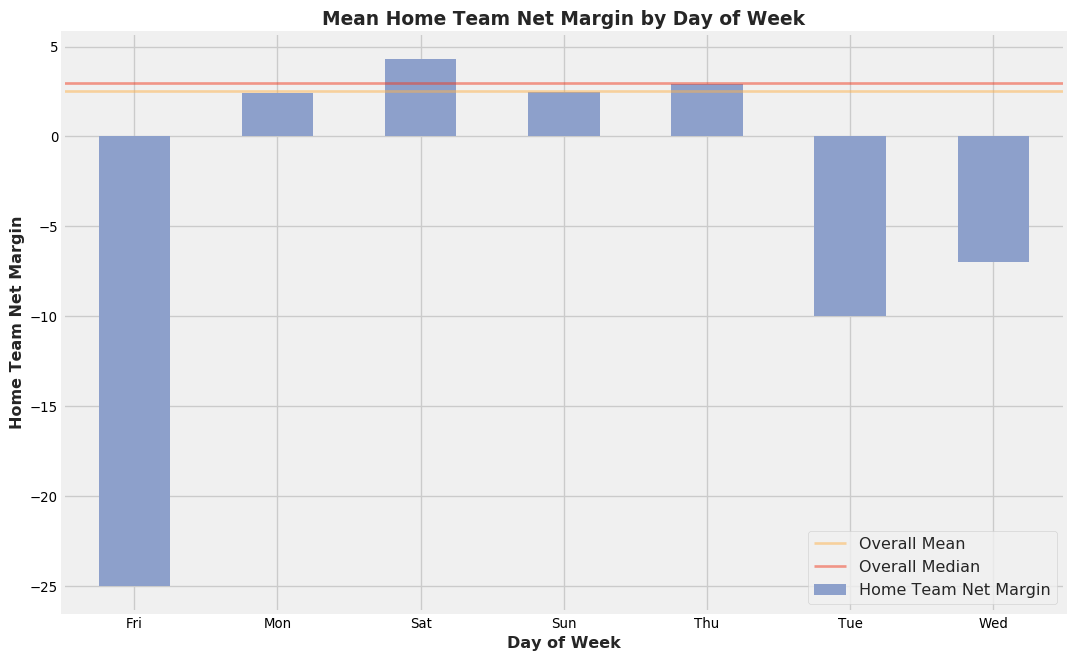

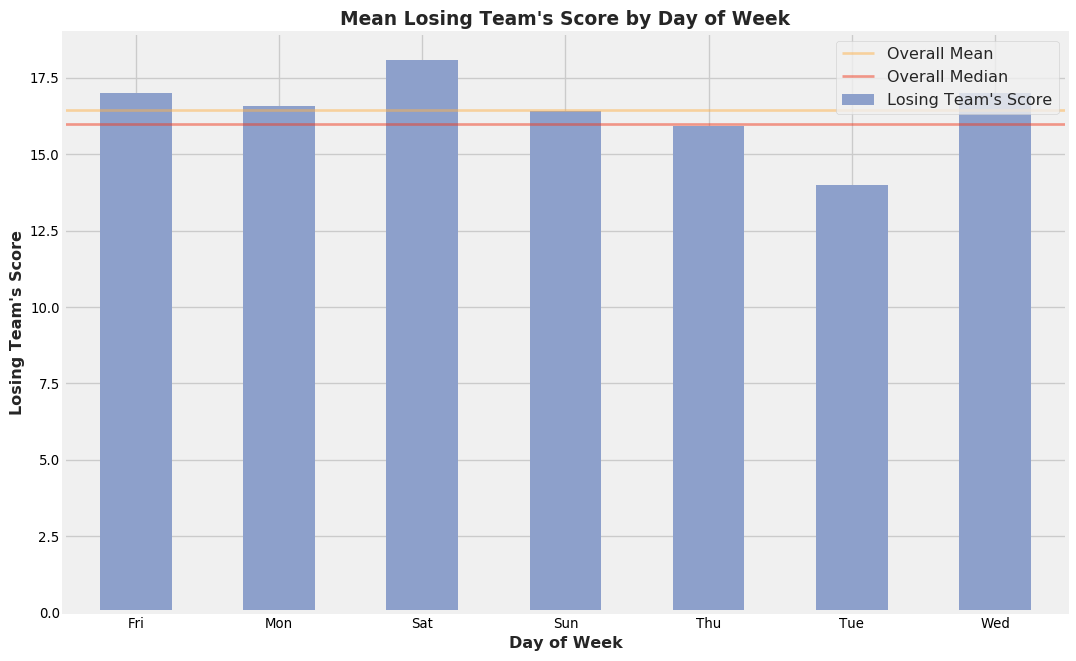

In [20]:
fields = [
    ('season','Season'), 
    ('week_id','Week'), 
    ('Weekday','Day of Week')
]
agg_cols = [
    ('winning_score','Winning Score'), 
    ('winning_margin','Winning Margin'), 
    ('home_net','Home Team Net Margin'), 
    ('losing_score', 'Losing Team\'s Score')
]

for i, (field, field_desc) in enumerate(fields):
    for (agg_col, agg_col_desc) in agg_cols:
        _ = df.groupby(field)\
                .agg(F.mean(agg_col).alias(agg_col))\
                .toPandas()\
                .set_index(field)\
                .rename(columns={agg_col:agg_col_desc})\
                .sort_index()\
                .plot(
                    kind='bar', rot=0, figsize=(12,8), color=colors[i]
                )
        mean_val = df.select(F.mean(agg_col)).toPandas().iloc[0, 0]
        med_val = df.select(
                udf(lambda x: float(np.median(x)), FloatType())
                (F.collect_list(agg_col))
            ).toPandas().iloc[0, 0]
        _ = plt.axhline(y=mean_val, linewidth=2, color='#feb24c', 
                        alpha=0.5, label='Overall Mean')
        _ = plt.axhline(y=med_val, linewidth=2, color='#f03b20', 
                        alpha=0.5, label='Overall Median')
        _ = plt.title('Mean {} by {}'.format(agg_col_desc, field_desc))
        _ = plt.xlabel(field_desc)
        _ = plt.ylabel(agg_col_desc)
        _ = plt.legend()

### Exploring League-wide Line Trends

#### Prep Data

In [21]:
key = 'game_id'
lines = spark.table('game_line')
drop_cols = filter(lambda x: '2h' in x, lines.columns)
lines = lines.drop(*drop_cols)

game = spark.table('game')\
                .select('game_id','season','week_id','is_neutral')\
                .cache()

meta = spark.table('game_metadata')\
                .select('game_id','day_of_week')\
                .cache()

In [22]:
lines.limit(5).toPandas()

,game_id,ml_fav,h_ml,v_ml,open_fav,open_spread,close_fav,close_spread,open_ou,close_ou,pfr_ou,pfr_spread,pfr_fav,pfr_fav_id
0,201511150ram,H,-380,310,H,7.0,H,7.5,43.0,42.0,42.5,6.5,H,ram
1,201511090sdg,H,-200,170,H,4.5,H,3.5,52.0,49.5,49.5,4.5,H,sdg
2,201510180det,H,-200,170,H,3.0,H,3.5,44.0,45.0,44.0,3.0,H,det
3,201512270tam,H,-165,145,H,2.5,H,3.0,46.5,43.5,45.0,3.0,H,tam
4,201510110kan,H,-428,347,H,10.0,H,9.0,46.5,43.5,45.0,9.0,H,kan


In [23]:
df = lines.join(game, on=key)\
          .join(meta, on=key)\
          .cache()
assert lines.count() == df.count()
assert game.count() == df.count()
assert meta.count() == df.count()

df = df.filter(col('is_neutral') == 0)

In [24]:
df.limit(5).toPandas()

,game_id,ml_fav,h_ml,v_ml,open_fav,open_spread,close_fav,close_spread,open_ou,close_ou,pfr_ou,pfr_spread,pfr_fav,pfr_fav_id,season,week_id,is_neutral,day_of_week
0,201511150ram,H,-380,310,H,7.0,H,7.5,43.0,42.0,42.5,6.5,H,ram,2015,10,0,6
1,201511090sdg,H,-200,170,H,4.5,H,3.5,52.0,49.5,49.5,4.5,H,sdg,2015,9,0,0
2,201510180det,H,-200,170,H,3.0,H,3.5,44.0,45.0,44.0,3.0,H,det,2015,6,0,6
3,201512270tam,H,-165,145,H,2.5,H,3.0,46.5,43.5,45.0,3.0,H,tam,2015,16,0,6
4,201510110kan,H,-428,347,H,10.0,H,9.0,46.5,43.5,45.0,9.0,H,kan,2015,5,0,6


#### How often is Home favorite? In open vs. close line?

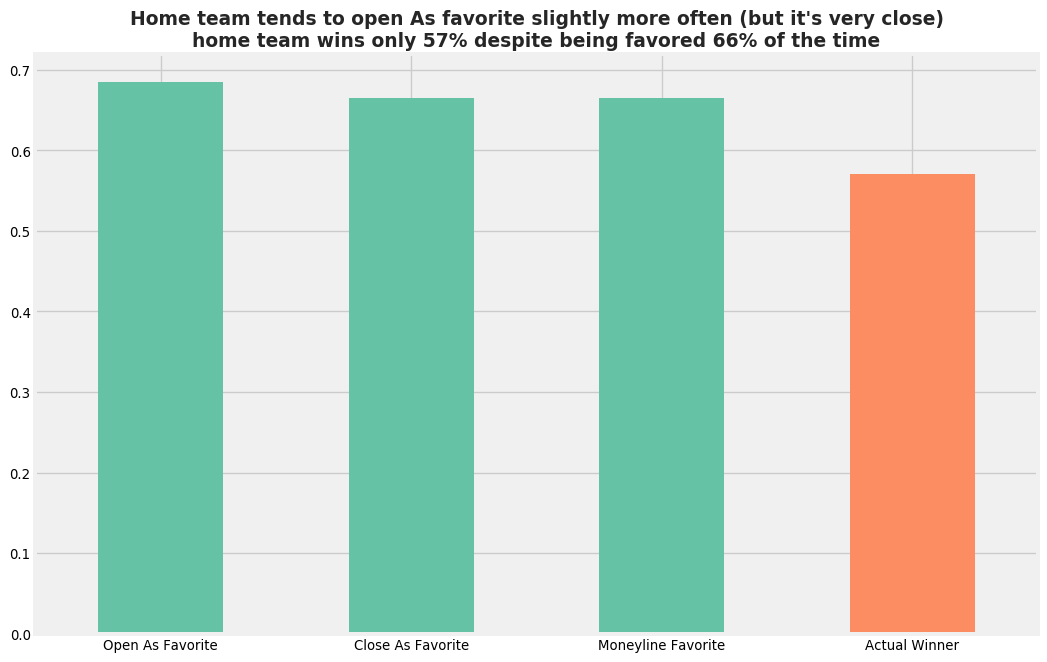

In [25]:
a = df.groupby('open_fav')\
      .count()\
      .toPandas()\
      .set_index('open_fav')\
      .rename(columns={'count':'Open As Favorite'})

b = df.groupby('close_fav')\
      .count()\
      .toPandas()\
      .set_index('close_fav')\
      .rename(columns={'count':'Close As Favorite'})

c = df.groupby('ml_fav')\
      .count()\
      .toPandas()\
      .set_index('ml_fav')\
      .rename(columns={'count':'Moneyline Favorite'})

winners = winners.rename(columns={'count':'Actual Winner'})
## winners DF is the actual winners

opcl = a.merge(b, left_index=True, right_index=True)\
        .merge(c, left_index=True, right_index=True)\
        .merge(winners, left_index=True, right_index=True)\
        .fillna(0)\
        .T
opcl['Home Prop'] = opcl['H'].astype(float) / opcl.sum(axis=1)

opcl['Home Prop'].plot(
    kind='bar', rot=0, legend=None, 
    color=[colors[0], colors[0], colors[0], colors[1]],
    title='Home team tends to open As favorite slightly more often '
          + '(but it\'s very close)\n'
          + 'home team wins only 57% despite being favored 66% of the time'
)

#### Comparing PFR Line to SBR

In [26]:
## standardize the lines: negative means home fav
df = df.withColumn(
        'sbr_open',
        F.when(col('open_fav') == 'H', -1*col('open_spread'))
         .when(col('open_fav') == 'V', col('open_spread'))
         .otherwise(0)
    ).withColumn(
        'sbr_close',
        F.when(col('close_fav') == 'H', -1*col('close_spread'))
         .when(col('close_fav') == 'V', col('close_spread'))
         .otherwise(0)
    ).withColumn(
        'pfr',
        F.when(col('pfr_fav') == 'H', -1*col('pfr_spread'))
         .when(col('pfr_fav') == 'V', col('pfr_spread'))
         .otherwise(0)
    )

In [27]:
df.select('sbr_open','sbr_close','pfr').limit(5).toPandas()

,sbr_open,sbr_close,pfr
0,-7.0,-7.5,-6.5
1,-4.5,-3.5,-4.5
2,-3.0,-3.5,-3.0
3,-2.5,-3.0,-3.0
4,-10.0,-9.0,-9.0


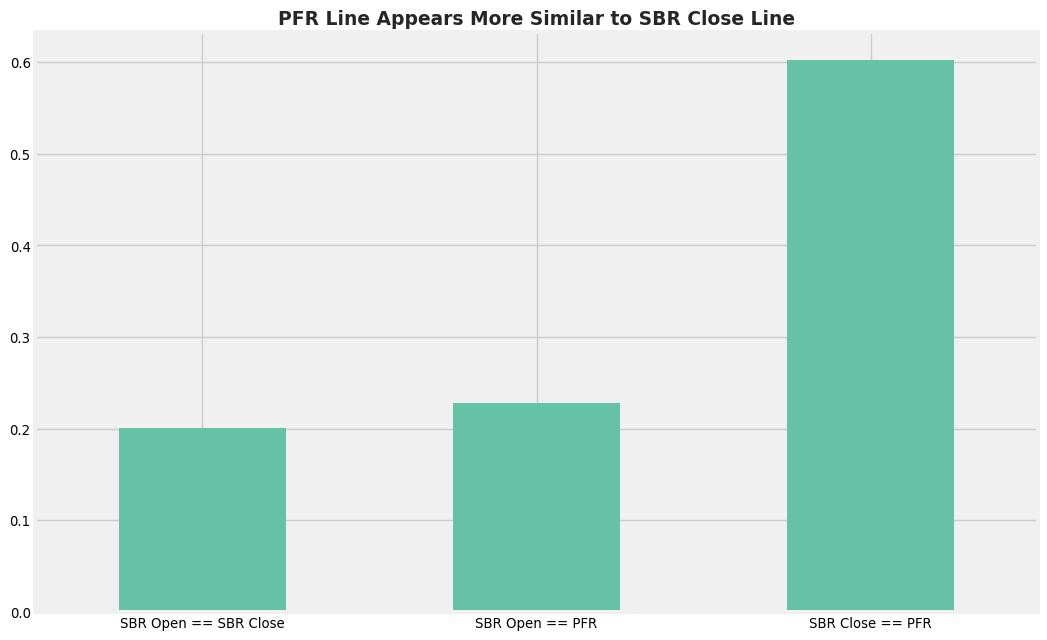

In [28]:
## how often are they equal
df.select('sbr_open','sbr_close','pfr').withColumn(
        'SBR Open == SBR Close',
        (col('sbr_open') == col('sbr_close')).cast(IntegerType())
    ).withColumn(
        'SBR Open == PFR',
        (col('sbr_open') == col('pfr')).cast(IntegerType())
    ).withColumn(
        'SBR Close == PFR',
        (col('sbr_close') == col('pfr')).cast(IntegerType())
    ).select(
        F.mean('SBR Open == SBR Close').alias('SBR Open == SBR Close'),
        F.mean('SBR Open == PFR').alias('SBR Open == PFR'),
        F.mean('SBR Close == PFR').alias('SBR Close == PFR')
    ).toPandas().T.plot(
        kind='bar', rot=0, legend=None,
        title='PFR Line Appears More Similar to SBR Close Line'
    )

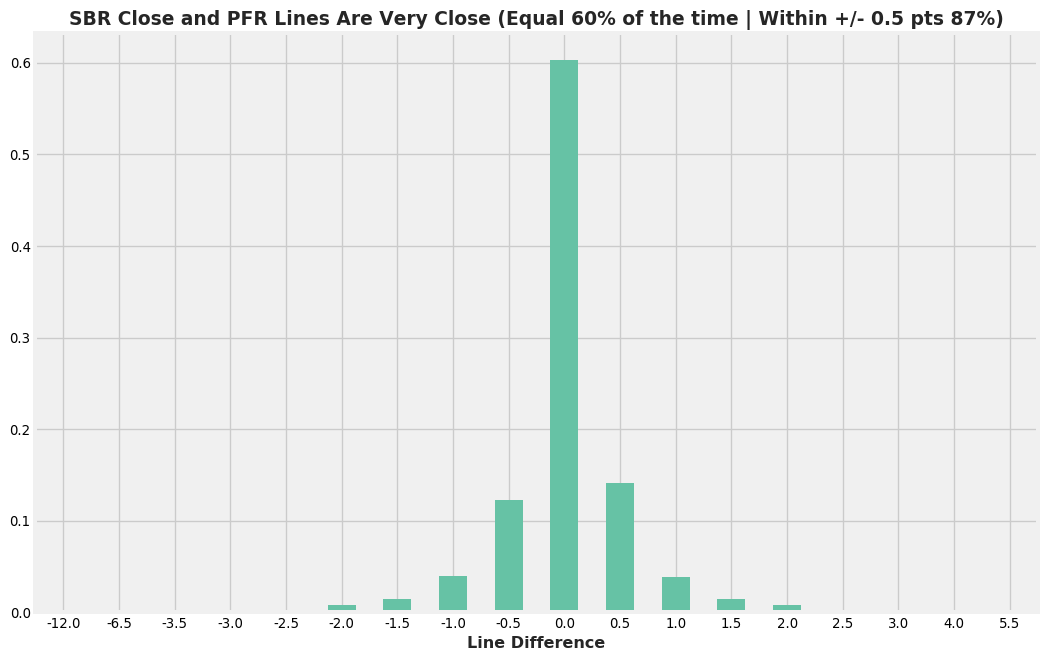

In [29]:
ngames = F.lit(float(df.count()))
df.withColumn(
        'prop', 
        F.lit(1) / ngames
    ).withColumn(
        'Line Difference',
        col('sbr_close') - col('pfr')
    ).groupby('Line Difference')\
    .agg(F.sum('prop').alias('prop'))\
    .toPandas()\
    .set_index('Line Difference')\
    .sort_index()\
    .plot(kind='bar', legend=None, rot=0,
         title='SBR Close and PFR Lines Are Very Close ' \
               '(Equal 60% of the time | Within +/- 0.5 pts 87%)')

#### How does the SBR line shift from open to close?

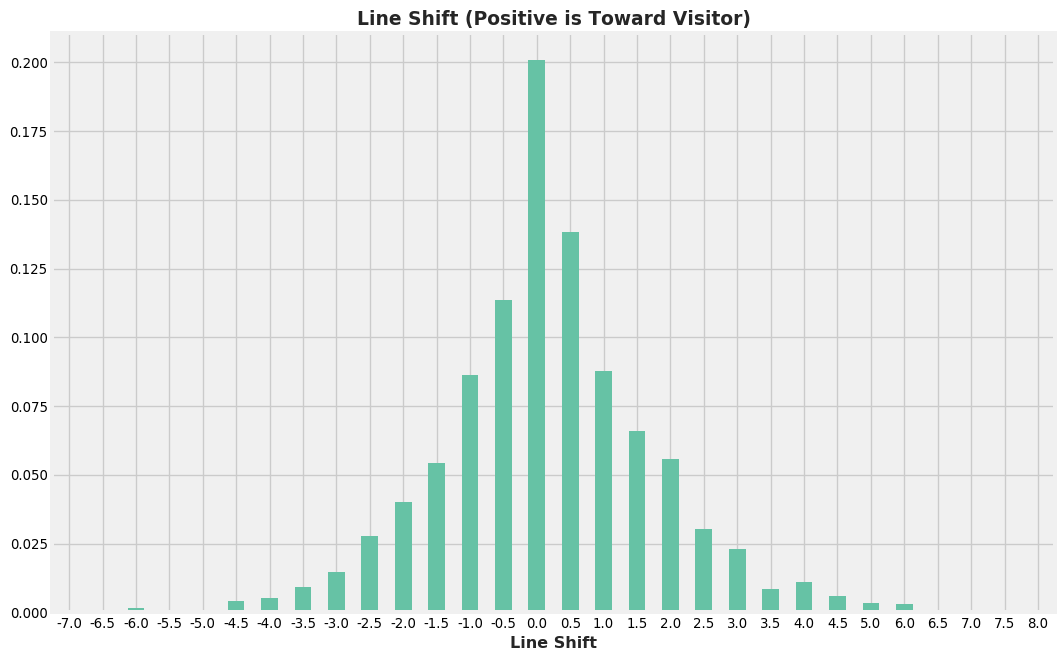

In [30]:
ngames = F.lit(float(df.count()))
df.withColumn(
        'prop', 
        F.lit(1) / ngames
    ).withColumn(
        'Line Shift',
        col('sbr_close') - col('sbr_open')
    ).groupby('Line Shift')\
    .agg(F.sum('prop').alias('prop'))\
    .toPandas()\
    .set_index('Line Shift')\
    .sort_index()\
    .loc[-7.:8., :]\
    .plot(kind='bar', legend=None, rot=0,
         title='Line Shift (Positive is Toward Visitor)')

#### Moneyline Favorites

In [31]:
def bin_ml(x, minv=-1000, maxv=500):
    max_ml = max(x, minv)
    min_ml = min(max_ml, maxv)
    return int(min_ml)

def bin_ml_frmt(x, minv=-1000, maxv=500):
    if x == 100:
        return 'PK'
    elif x == minv:
        return '<= {}'.format(minv)
    elif x == maxv:
        return '+{}+'.format(maxv)
    elif x < 0:
        return str(int(x))
    else:
        return '+' + str(int(x))

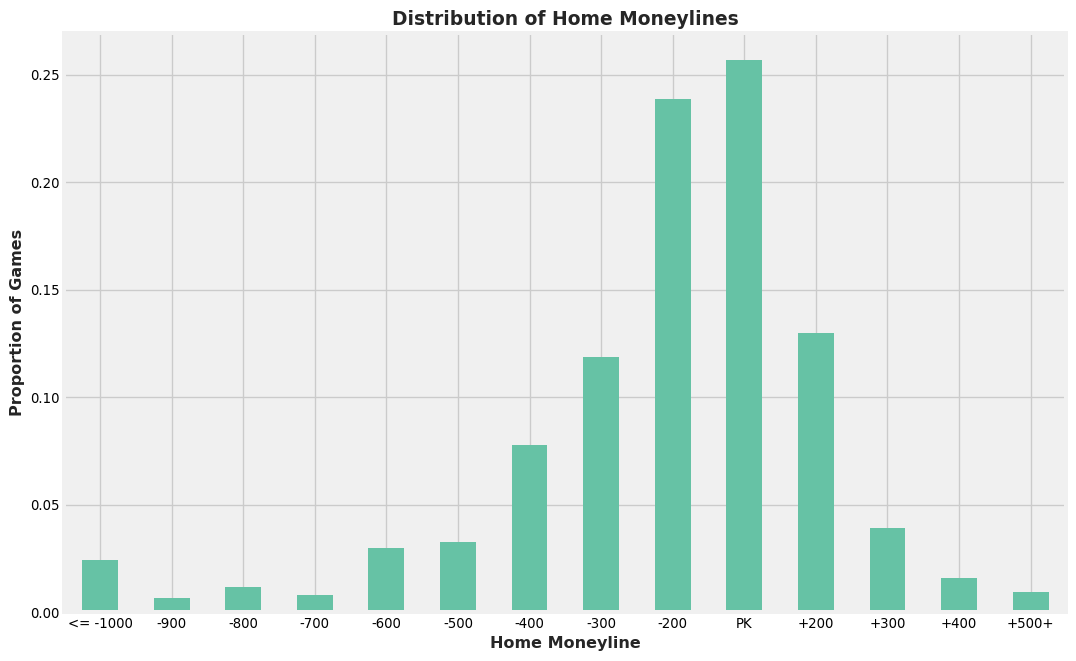

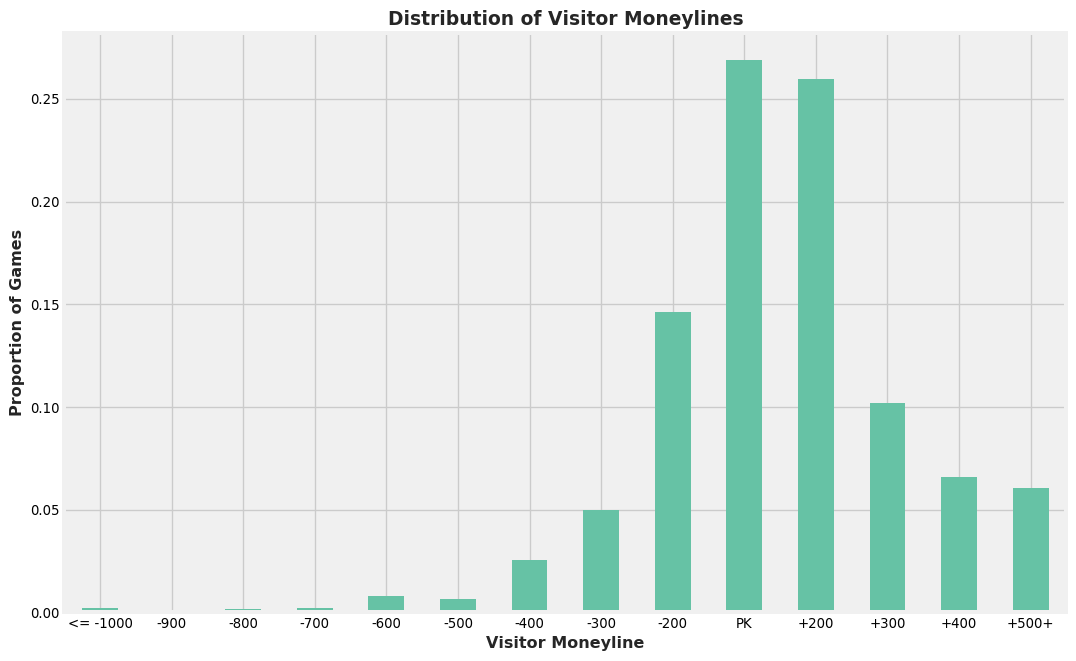

In [32]:
ml_grps = {}
for colname, agg_col in [('Home Moneyline','h_ml'), 
                         ('Visitor Moneyline','v_ml')]:

    ml_agg = agg_scores(df, ngames, agg_col).reset_index(drop=False)
    ml_agg['{}_rnd'.format(agg_col)] = ml_agg[agg_col].apply(
            lambda x: np.round(x/100.)*100
        )
    ml_agg['{}_rnd'.format(agg_col)] = ml_agg['{}_rnd'.format(agg_col)].apply(
            lambda x: 100. if x == -100. else x
        )
    ml_agg_grp = ml_agg[['{}_rnd'.format(agg_col),'prop']]\
                    .groupby('{}_rnd'.format(agg_col))\
                    .sum()\
                    .reset_index(drop=False)
    ml_agg_grp[colname] = ml_agg_grp['{}_rnd'.format(agg_col)].apply(bin_ml)
    ml_agg_grp = ml_agg_grp[[colname,'prop']]\
                    .groupby(colname)\
                    .sum()\
                    .reset_index(drop=False)
    ml_agg_grp[colname] = ml_agg_grp[colname].apply(bin_ml_frmt)
    ml_agg_grp = ml_agg_grp[ml_agg_grp[colname] != '+0']
    ml_agg_grp = ml_agg_grp.set_index(colname).rename(
            columns={'prop': 'Proportion of Games'}
        )
    _ = ml_agg_grp.plot(
        kind='bar', rot=0, legend=None,
        title='Distribution of {}s'.format(colname)
    )
    _ = plt.ylabel('Proportion of Games')
    
    ml_grps[(colname, agg_col)] = ml_agg_grp

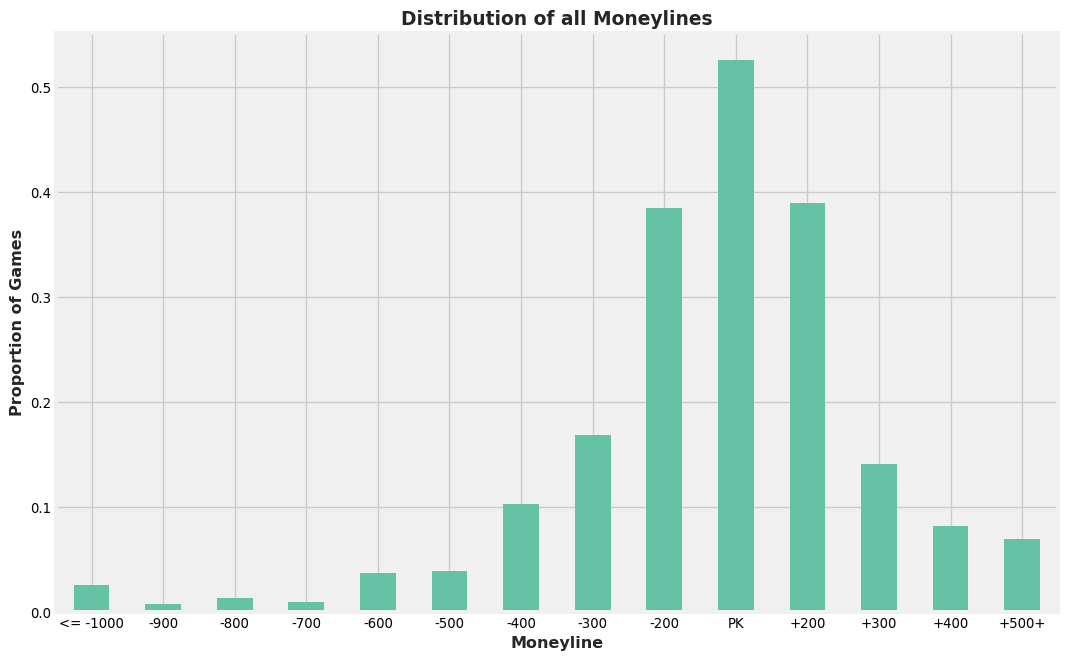

In [33]:
ml_dfs = []
for (colname, _), df_ in ml_grps.iteritems():
    ml_dfs.append(
        df_.reset_index(drop=False)\
           .rename(columns={colname: 'Moneyline'})
    )
    
ml_tot = reduce(
        lambda df1, df2: df1.append(df2).reset_index(drop=True), 
        ml_dfs
    ).groupby('Moneyline').sum()

ml_tot['sort_col'] = ml_tot.index
ml_tot['sort_col'] = ml_tot['sort_col'].apply(
    lambda x: int(x.replace('+','')
                   .replace('<= ','')
                   .replace('PK','100'))
)

_ = ml_tot.sort_values(by='sort_col')[['Proportion of Games']].plot(
    kind='bar', rot=0, legend=None, title='Distribution of all Moneylines'
)
_ = plt.ylabel('Proportion of Games')

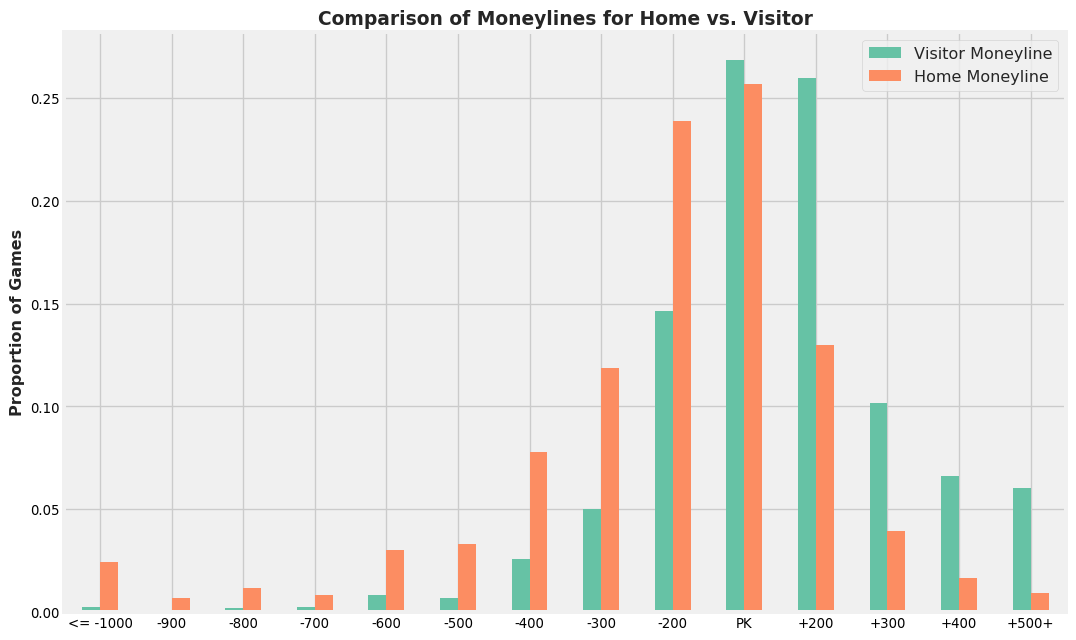

In [34]:
ml_dfs = []
for (colname, _), df_ in ml_grps.iteritems():
    ml_dfs.append(
        df_.rename(columns={'Proportion of Games':colname})
    )
ml_comp = ml_dfs[0].merge(
        ml_dfs[1], left_index=True, 
        right_index=True, how='outer'
    )

ml_comp['sort_col'] = ml_comp.index
ml_comp['sort_col'] = ml_comp['sort_col'].apply(
    lambda x: int(x.replace('+','')
                   .replace('<= ','')
                   .replace('PK','100'))
)

_ = ml_comp.sort_values(by='sort_col')\
           .drop('sort_col', axis=1)\
           .plot(kind='bar', rot=0, 
                 title='Comparison of Moneylines for Home vs. Visitor')
_ = plt.ylabel('Proportion of Games')

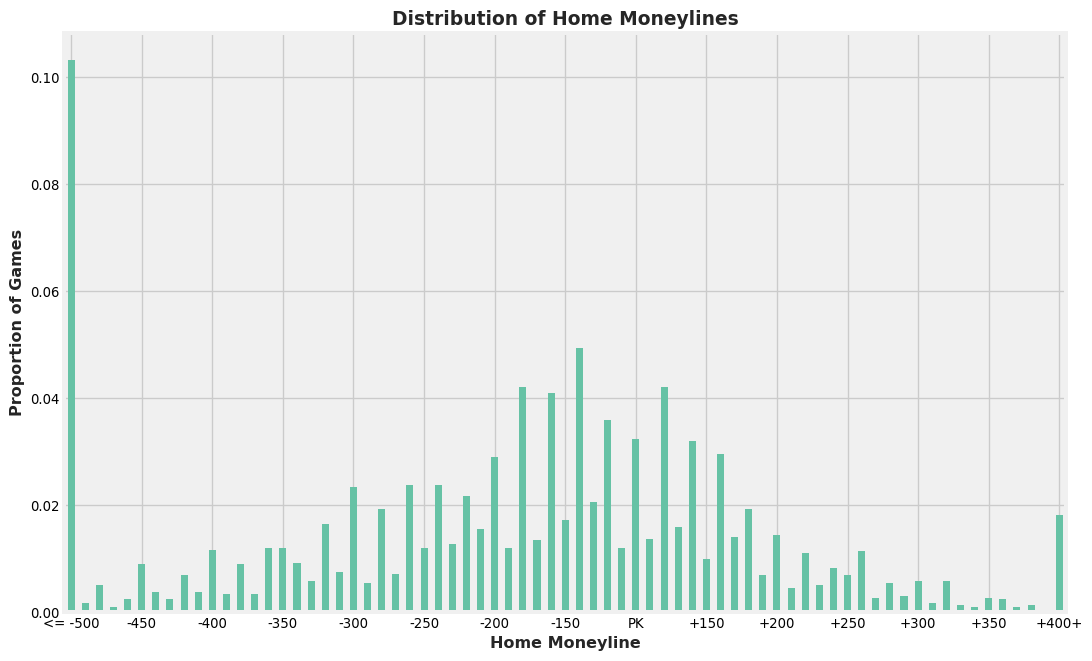

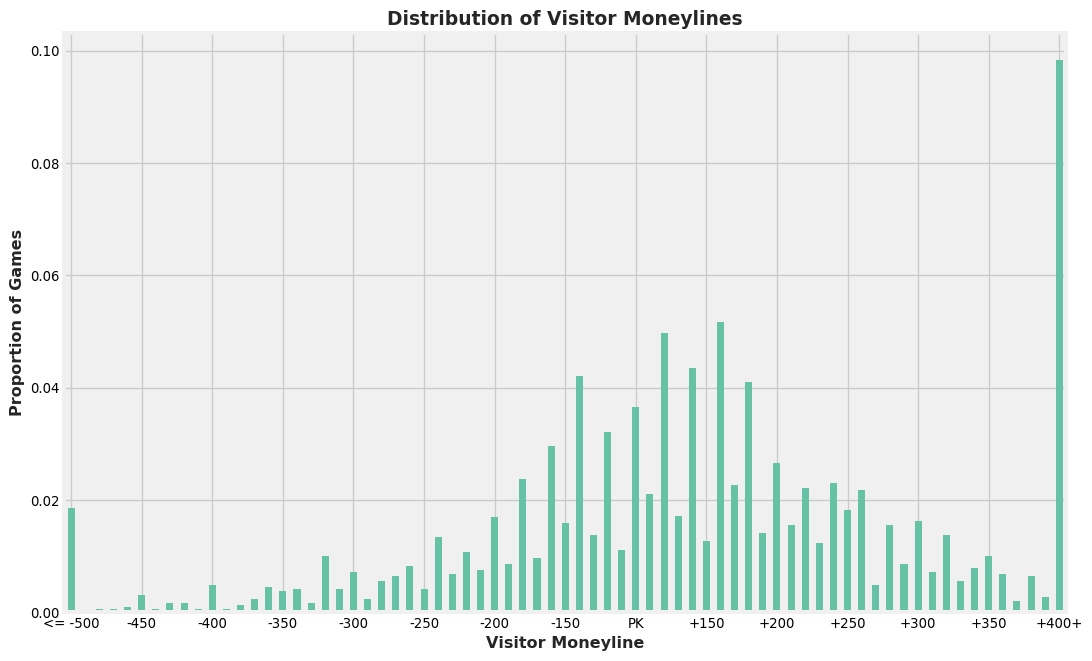

In [35]:
colname = 'All Moneylines'
minv = -500
maxv = 400

ml_grps = {}
for colname, agg_col in [('Home Moneyline','h_ml'), 
                         ('Visitor Moneyline','v_ml')]:

    ml_agg = agg_scores(df, ngames, agg_col).reset_index(drop=False)

    ml_agg['{}_rnd'.format(agg_col)] = ml_agg[agg_col].apply(
        lambda x: np.round(x/10.)*10
    )
    ml_agg['{}_rnd'.format(agg_col)] = ml_agg['{}_rnd'.format(agg_col)].apply(
            lambda x: 100. if x == -100. else x
        )

    ml_agg_grp = ml_agg[['{}_rnd'.format(agg_col),'prop']]\
                    .groupby('{}_rnd'.format(agg_col))\
                    .sum()\
                    .reset_index(drop=False)
    ml_agg_grp[colname] = ml_agg_grp['{}_rnd'.format(agg_col)].apply(
        lambda x: bin_ml(x, minv, maxv)
    )
    ml_agg_grp = ml_agg_grp[[colname,'prop']]\
                    .groupby(colname)\
                    .sum()\
                    .reset_index(drop=False)
    ml_agg_grp = ml_agg_grp[
        (ml_agg_grp[colname] >= 100)
        | (ml_agg_grp[colname] <= -100)
    ]
    ml_agg_grp[colname] = ml_agg_grp[colname].apply(
        lambda x: bin_ml_frmt(x, minv, maxv)
    )
    ml_agg_grp = ml_agg_grp[ml_agg_grp[colname] != '+0']
    
    ml_agg_grp = ml_agg_grp.set_index(colname).rename(
            columns={'prop': 'Proportion of Games'}
        )
    _ = ml_agg_grp.plot(
        kind='bar', rot=0, legend=None,
        title='Distribution of {}s'.format(colname)
    )
    _ = plt.ylabel('Proportion of Games')
    a, b = plt.xticks()
    _ = plt.xticks(a[::5], b[::5])
    
    ml_grps[(colname, agg_col)] = ml_agg_grp

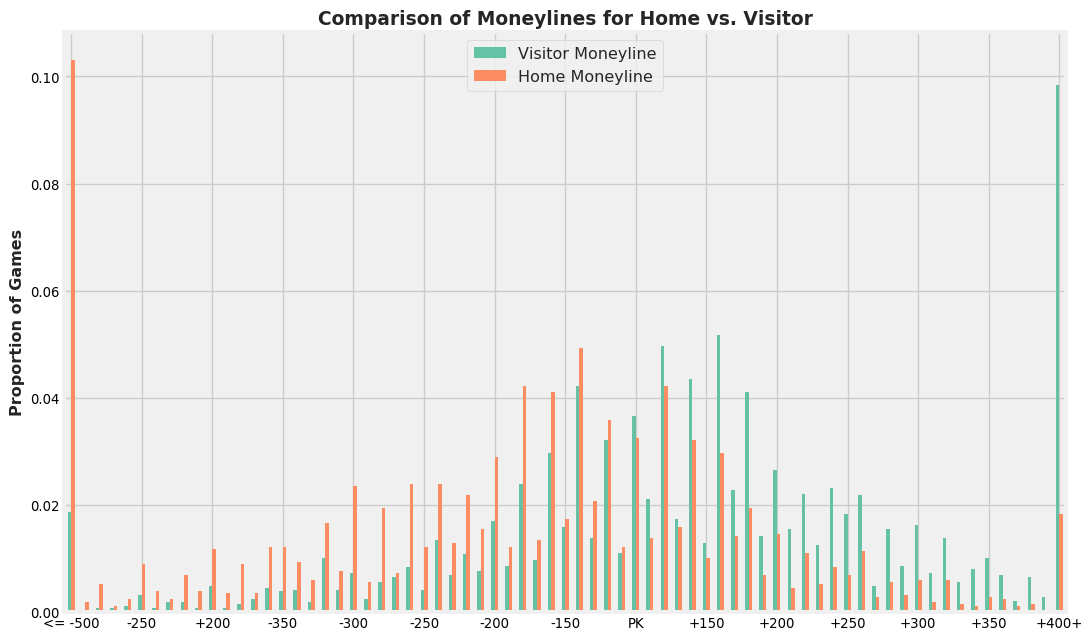

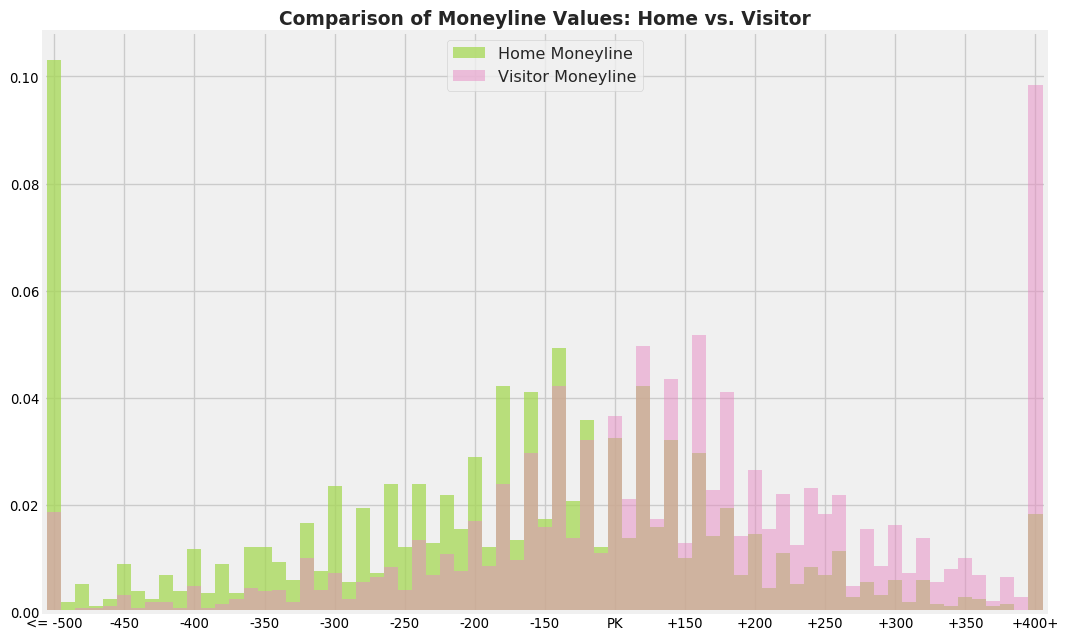

In [36]:
ml_dfs = []
for (colname, _), df_ in ml_grps.iteritems():
    ml_dfs.append(
        df_.rename(columns={'Proportion of Games':colname})
    )
ml_comp = ml_dfs[0].merge(
        ml_dfs[1], left_index=True, 
        right_index=True, how='outer'
    )

ml_comp['sort_col'] = ml_comp.index
ml_comp['sort_col'] = ml_comp['sort_col'].apply(
    lambda x: int(x.replace('+','')
                   .replace('<= ','')
                   .replace('PK','100'))
)

_ = ml_comp.sort_values(by='sort_col')\
           .drop('sort_col', axis=1)\
           .plot(kind='bar', rot=0, 
                 title='Comparison of Moneylines for Home vs. Visitor')
_ = plt.ylabel('Proportion of Games')
_ = plt.xticks(a[::5], b[::5])


ax = plt.figure().add_subplot(111)

_  = ml_comp['Home Moneyline'].plot(
        kind='bar', rot=0, width=1, ax=ax, color=colors[4], alpha=0.75,
        title='Comparison of Moneyline Values: Home vs. Visitor'
    )
_  = ml_comp['Visitor Moneyline'].plot(
        kind='bar', rot=0, width=1, color=colors[3], ax=ax, alpha=0.5
    )

a, b = plt.xticks()
_ = plt.xticks(a[::5], b[::5])
_ = plt.legend()

#### Moneylines represented as breakeven win probability

In [37]:
ml_probs = df
for h_v in ['h','v']:
    ml_col = '{}_ml'.format(h_v)
    prob_col = '{} Moneyline Breakeven Point'.format(h_v)
    ml_probs = ml_probs.withColumn(
            prob_col,
            F.when(col(ml_col) <= 0, -col(ml_col) / (F.lit(100.) - col(ml_col)))
             .otherwise(F.lit(100.) / (F.lit(100.) + col(ml_col)))
        ).withColumn(
            prob_col, F.round(col(prob_col)*100, 0) / F.lit(100.)
        )

ml_prob_aggs = []
for h_v in ['h','v']:
    prob_col = '{} Moneyline Breakeven Point'.format(h_v)
    prob_col_base = ' '.join(prob_col.split(' ')[1:])
    
    h_v_str = 'Home' if h_v == 'h' else 'Visitor'

    curr_df = ml_probs.groupby(prob_col)\
                      .agg(F.count(F.lit(1)).alias(h_v_str))\
                      .withColumnRenamed(prob_col, prob_col_base)\
                      .toPandas()\
                      .set_index(prob_col_base)\
                      .sort_index()

    curr_tot = curr_df[h_v_str].astype(float).sum()
    curr_df[h_v_str] /= curr_tot
    
    new_index = np.arange(0, 1.01, 0.01)
    ml_prob_aggs.append(
        curr_df.reindex(new_index)
               .fillna(0)
               .reset_index(drop=False)
               .set_index('Moneyline Breakeven Point')
    )

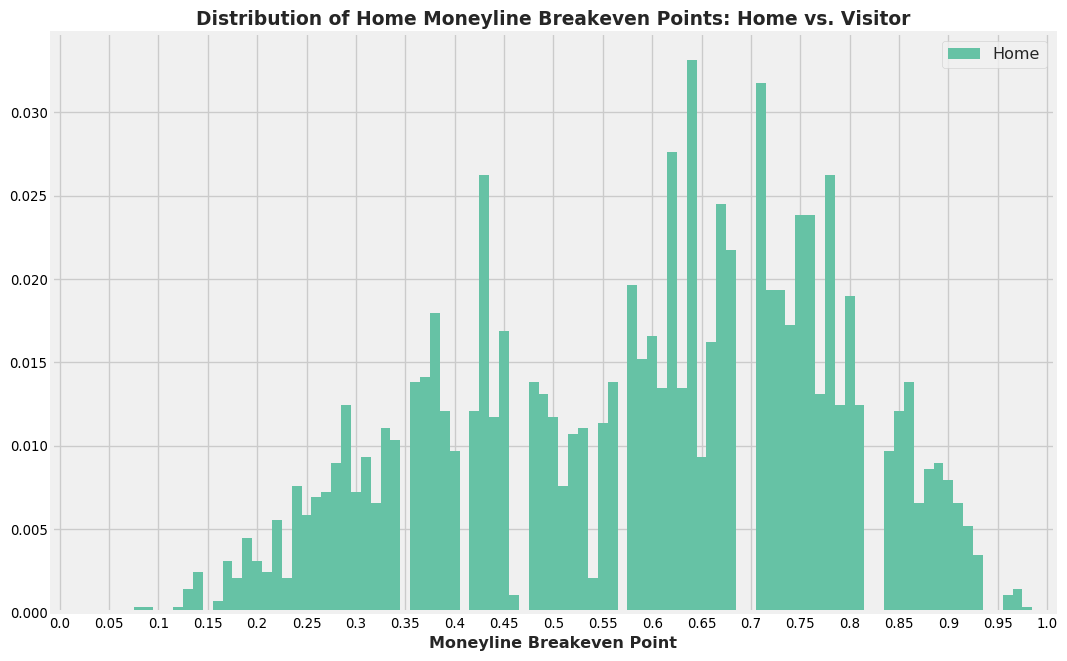

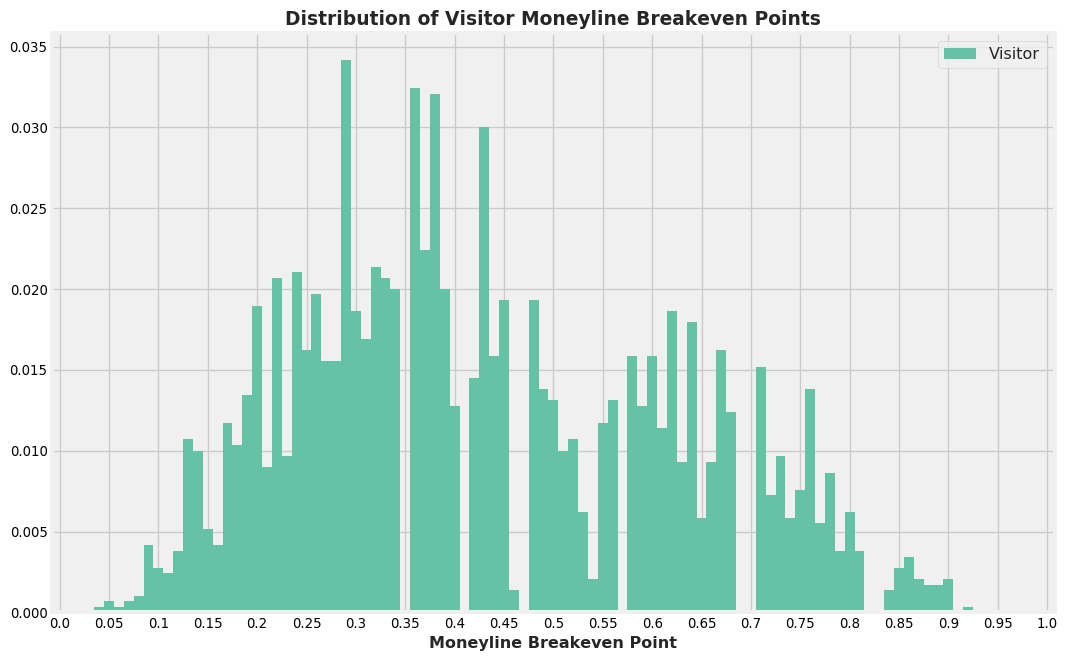

In [38]:
ml_prob_aggs[0].plot(
        kind='bar', rot=0, width=1,
        title='Distribution of Home Moneyline Breakeven Points: Home vs. Visitor'
    )
a, b = plt.xticks()
_ = plt.xticks(a[::5], b[::5])
ml_prob_aggs[1].plot(
        kind='bar', rot=0, width=1,
        title='Distribution of Visitor Moneyline Breakeven Points'
    )
a, b = plt.xticks()
_ = plt.xticks(a[::5], b[::5])

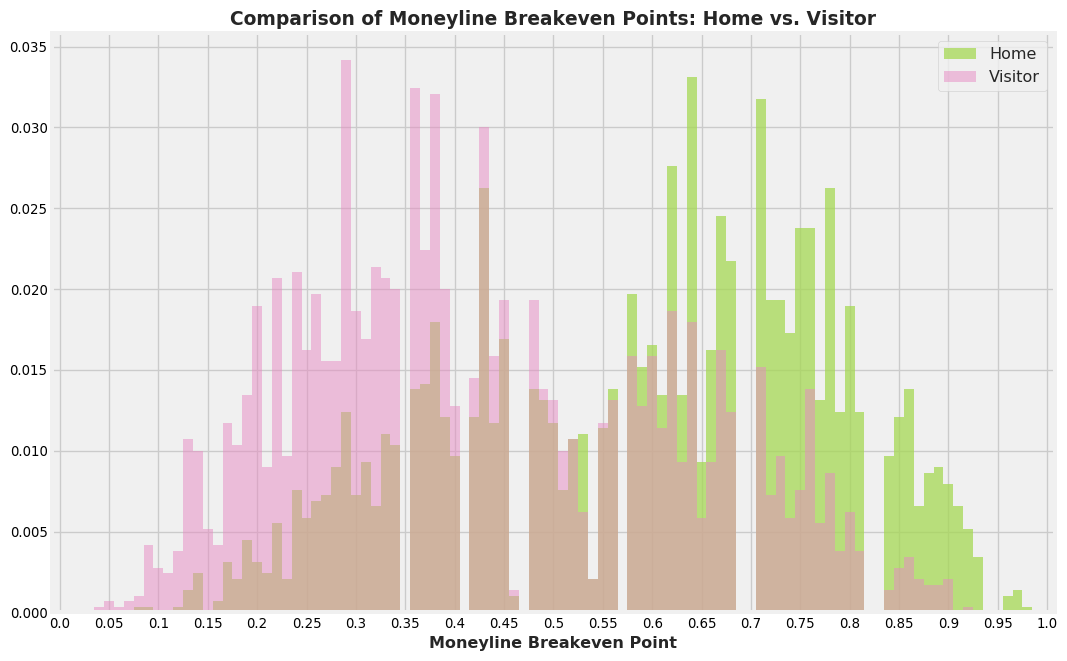

In [39]:
ax = plt.figure().add_subplot(111)

ml_prob_aggs[0].plot(
        kind='bar', rot=0, width=1, ax=ax, color=colors[4], alpha=0.75,
        title='Comparison of Moneyline Breakeven Points: Home vs. Visitor'
    )
ml_prob_aggs[1].plot(
        kind='bar', rot=0, width=1, color=colors[3], ax=ax, alpha=0.5,
        figsize=(12,8)
    )

a, b = plt.xticks()
_ = plt.xticks(a[::5], b[::5])

#### Have Lines Priced Home-Field Advantage Differently over Time?

In [40]:
curr_df = df.groupby('season')\
            .agg(F.mean(ml_col).alias(ml_col))\
            .fillna(0)\
            .toPandas()

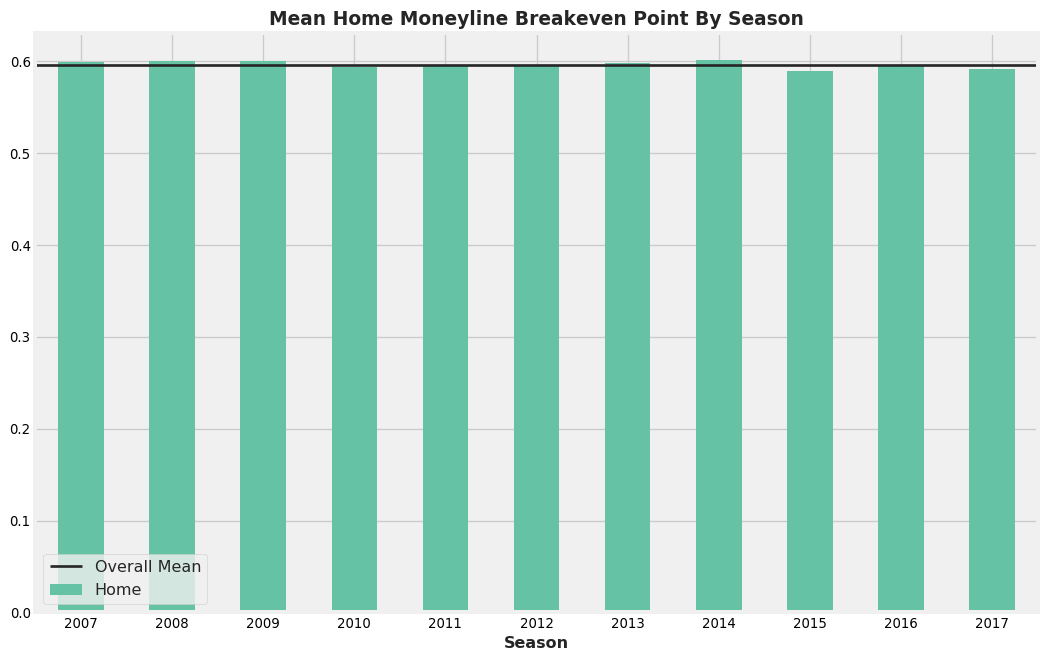

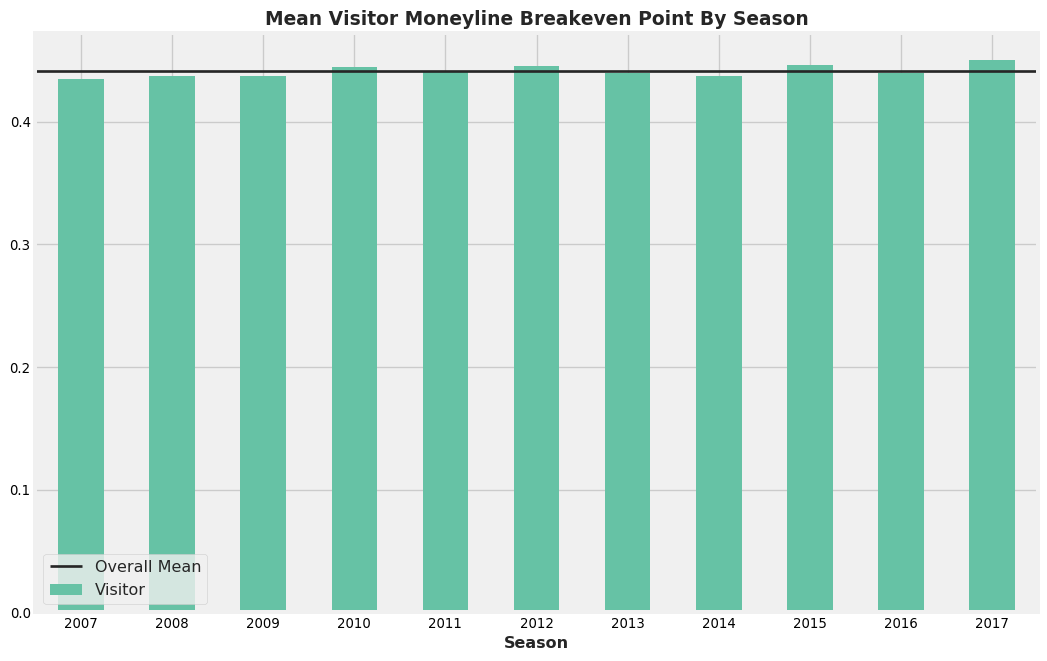

In [41]:
for h_v in ['h','v']:
    ml_col = '{}_ml'.format(h_v)
    h_v_str = 'Home' if h_v == 'h' else 'Visitor'
    prob_col = '{} Moneyline Breakeven Point'.format(h_v)
    tot_mean = ml_probs.select(F.mean(prob_col).alias(h_v_str))\
                       .toPandas()\
                       .iloc[0, 0]
    _ = ml_probs.groupby('season')\
            .agg(F.mean(prob_col).alias(h_v_str))\
            .fillna(0)\
            .toPandas()\
            .rename(columns={'season':'Season'})\
            .set_index('Season')\
            .sort_index()\
            .plot(
                kind='bar', rot=0,
                title='Mean {} Moneyline Breakeven Point By Season'
                         .format(h_v_str)
            )
    _ = plt.axhline(y=tot_mean, color='#262626', linewidth=2, label='Overall Mean')
    _ = plt.legend()